### Setup

In [1]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
from numpy.linalg import multi_dot
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, silhouette_samples
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from pyvis.network import Network
from scipy.spatial.distance import pdist, squareform
from umap import UMAP
import tanglegram2 as tg
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)
reload(tg)

<module 'tanglegram2' from '/home/louiscam/projects/gpcr/code/figures3/tanglegram2.py'>

In [2]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Directory of proteins of interest
dir_proteins = '/home/louiscam/projects/gpcr/data/protein_families/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load data

In [4]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

In [52]:
# All active genes
all_active_genes = pickle.load(open(saving_dir+'all_active_genes.pkl', 'rb'))
all_inactive_genes = pickle.load(open(saving_dir+'all_inactive_genes.pkl', 'rb'))

In [5]:
# Mapping gene to chromosome
gene2chrom = pickle.load(open(saving_dir+'gene2chrom.pkl', 'rb'))

In [6]:
# Adhesome genes and loci
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl', 'rb'))
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_genes_loci.pkl', 'rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl', 'rb'))

In [7]:
# Adhesome TF genes and loci
active_lung_adhesome_tf_genes = pickle.load(open(saving_dir+'active_lung_adhesome_tf_genes.pkl','rb'))
active_lung_adhesome_tf_loci = pickle.load(open(saving_dir+'active_lung_adhesome_tf_loci.pkl','rb'))

In [8]:
# Selected genes = Adhesome genes + adhesome TFs
selected_genes = np.unique(np.concatenate([active_adhesome_genes,active_lung_adhesome_tf_genes], axis=0))
selected_loci = np.unique(np.concatenate([active_adhesome_loci,active_lung_adhesome_tf_loci], axis=0))
selected_gene2locus = pickle.load(open(saving_dir+'adh_and_tf_gene2locus.pkl','rb'))
selected_locus2gene = pickle.load(open(saving_dir+'adh_and_tf_locus2gene.pkl','rb'))
adh_and_tf_chr_loci = pickle.load(open(saving_dir+'adh_and_tf_chr_loci.pkl','rb'))
contacts_df = pickle.load(open(saving_dir+'contacts_df.pkl','rb')).loc[selected_loci,selected_loci]

# Network of adhesome genes and adhesome TF genes

## Initial edges lists

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

## HiC and correlation distances

In [9]:
# Load edge lists
adhesome_interX_edge_list = pickle.load(open(saving_dir+'adhesome_interX_edge_list.pkl', 'rb'))
adhesome_intraX_edge_list = pickle.load(open(saving_dir+'adhesome_intraX_edge_list.pkl', 'rb'))

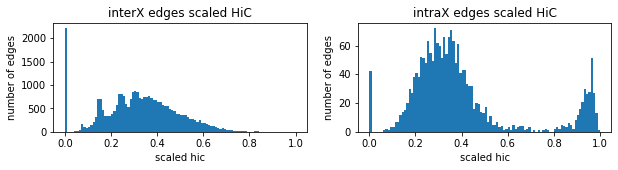

In [10]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(adhesome_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
# plt.vlines(x=np.quantile(adhesome_interX_edge_list['scaled_hic'],0.75), ymin=0, ymax=2000, 
#            color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')

plt.subplot(1, 2, 2)
plt.hist(adhesome_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
# plt.vlines(x=np.quantile(adhesome_intraX_edge_list['scaled_hic'],0.75), ymin=0, ymax=70, 
#            color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')

plt.show()

### Genomic features for each adhesome gene

In [11]:
# Load epigenomic features
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)
# Restrict to genes in cluster
df_cluster_norm = df_all_norm.loc[:,selected_genes]
# df_cluster_norm.values[:,:] = (df_cluster_norm.values-np.mean(df_cluster_norm.values, axis=1).reshape(-1,1))/np.std(df_cluster_norm.values, axis=1).reshape(-1,1)

/home/louiscam/anaconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


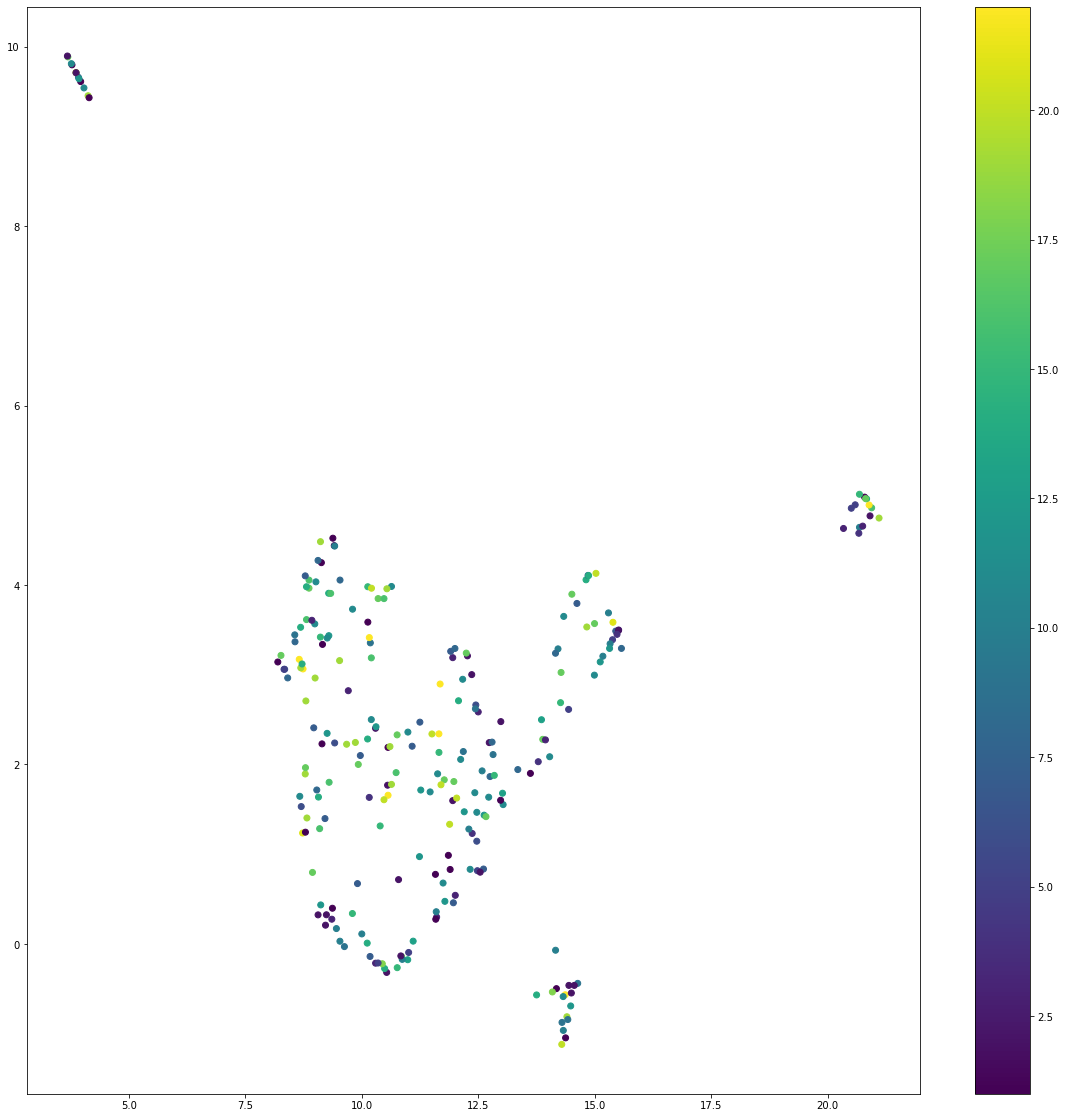

In [12]:
# UMAP of 
umap = UMAP(n_neighbors=10,
            min_dist=0.1,
            metric='correlation',
            n_components=2, init='random', random_state=0)
proj = umap.fit_transform(df_cluster_norm.T)
plt.figure(figsize=(20,20))
plt.scatter(proj[:,0],proj[:,1], c=[int(gene2chrom[g].split('chr')[1]) for g in df_cluster_norm.columns.values])
plt.colorbar()
plt.show()

In [13]:
# Create Pearson distance matrix
adhesome_pearson_distance_df = (1-df_cluster_norm.corr(method='pearson'))/2
# Create Spearman distance matrix
adhesome_spearman_distance_df = (1-df_cluster_norm.corr(method='spearman'))/2
# Create cosine distance matrix
adhesome_cosine_df = pd.DataFrame(
    squareform(pdist(df_cluster_norm.T, metric='cosine')),
    columns = df_cluster_norm.columns,
    index = df_cluster_norm.columns
)/2

In [14]:
# Add distance and Spearman correlation to interX edge list
adhesome_interX_edge_list['pearson_dist'] = [adhesome_pearson_distance_df.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                              adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
adhesome_interX_edge_list['spearman_dist'] = [adhesome_spearman_distance_df.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                                adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
adhesome_interX_edge_list['cosine_dist'] = [adhesome_cosine_df.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                                adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
# Add distance and Spearman correlation to intraX edge list
adhesome_intraX_edge_list['pearson_dist'] = [adhesome_pearson_distance_df.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                              adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
adhesome_intraX_edge_list['spearman_dist'] = [adhesome_spearman_distance_df.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                                adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
adhesome_intraX_edge_list['cosine_dist'] = [adhesome_cosine_df.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                                adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
print('Total number of edges = '+str(len(adhesome_intraX_edge_list)+len(adhesome_interX_edge_list)))

Total number of edges = 31626


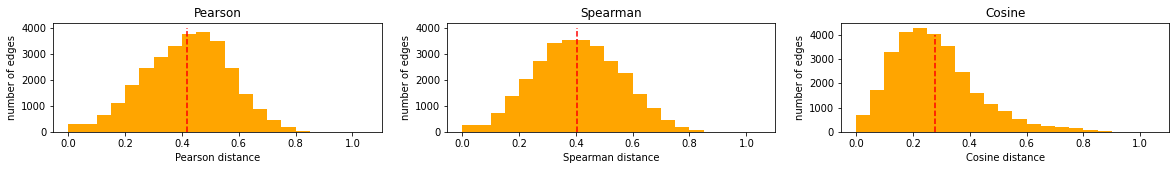

In [15]:
# Plot distribution of distance in selected edges
hic_threshold = 0.
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target',
                                                                                       'hic','scaled_hic',
                                                                                       'pearson_dist','spearman_dist',
                                                                                       'cosine_dist']]
all_selected = pd.concat([inter_selected, intra_selected], axis=0)
plt.figure(figsize=(20,2))
# Pearson
plt.subplot(1, 3, 1)
plt.hist(all_selected['pearson_dist'], 
         bins=np.arange(0,1.1,0.05),
        color='orange')
plt.vlines(x=np.mean(all_selected['pearson_dist']), ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.xlabel('Pearson distance')
plt.ylabel('number of edges')
plt.title('Pearson')

# Spearman
plt.subplot(1, 3, 2)
plt.hist(all_selected['spearman_dist'], 
         bins=np.arange(0,1.1,0.05),
        color='orange')
plt.vlines(x=np.mean(all_selected['spearman_dist']), ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.xlabel('Spearman distance')
plt.ylabel('number of edges')
plt.title('Spearman')

# Cosine
plt.subplot(1, 3, 3)
plt.hist(all_selected['cosine_dist'], 
         bins=np.arange(0,1.1,0.05),
        color='orange')
plt.vlines(x=np.mean(all_selected['cosine_dist']), ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.xlabel('Cosine distance')
plt.ylabel('number of edges')
plt.title('Cosine')

plt.show()

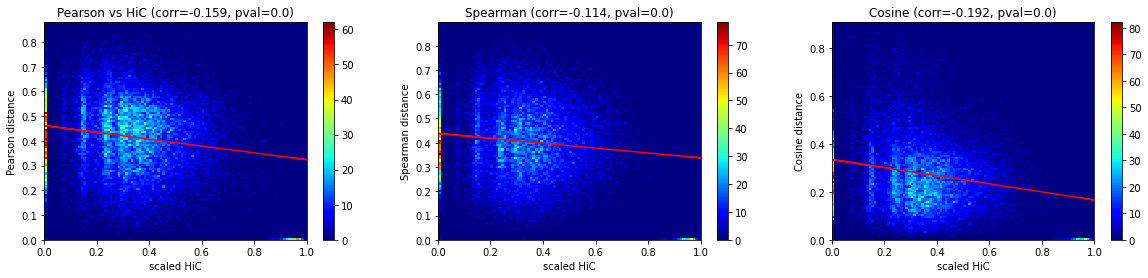

In [16]:
# Plot relationship between HiC and correlation distance
hic_threshold = 0.
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>=t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>=u][['source','target',
                                                                                       'hic','scaled_hic',
                                                                                       'pearson_dist','spearman_dist',
                                                                                       'cosine_dist']]
all_selected = pd.concat([inter_selected, intra_selected], axis=0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
# Pearson
x = all_selected['scaled_hic']
y = all_selected['pearson_dist']
h1 = ax1.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax1.plot(x, m*x+b, color='red')
ax1.set_xlabel('scaled HiC')
ax1.set_ylabel('Pearson distance')
fig.colorbar(h1[3], ax=ax1)
pearson = ss.pearsonr(x,y)
ax1.set_title('Pearson vs HiC (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')

# Spearman
x = all_selected['scaled_hic']
y = all_selected['spearman_dist']
h2 = ax2.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax2.plot(x, m*x+b, color='red')
ax2.set_xlabel('scaled HiC')
ax2.set_ylabel('Spearman distance')
fig.colorbar(h2[3], ax=ax2)
pearson = ss.pearsonr(x,y)
ax2.set_title('Spearman (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')

# Cosine
x = all_selected['scaled_hic']
y = all_selected['cosine_dist']
h3 = ax3.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax3.plot(x, m*x+b, color='red')
ax3.set_xlabel('scaled HiC')
ax3.set_ylabel('Cosine distance')
fig.colorbar(h3[3], ax=ax3)
pearson = ss.pearsonr(x,y)
ax3.set_title('Cosine (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')
plt.show()

## ROC-type curves for choice of distance

In [17]:
# Create list of selected edges
hic_threshold = 0.
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>=t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>=u][['source','target',
                                                                                       'hic','scaled_hic',
                                                                                       'pearson_dist','spearman_dist',
                                                                                       'cosine_dist']]
all_selected = pd.concat([inter_selected, intra_selected], axis=0)

100%|██████████| 31625/31625 [01:38<00:00, 322.37it/s]


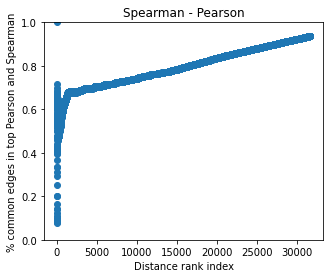

100%|██████████| 31625/31625 [01:35<00:00, 331.34it/s] 


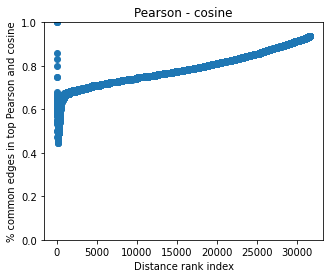

100%|██████████| 31625/31625 [01:34<00:00, 336.05it/s] 


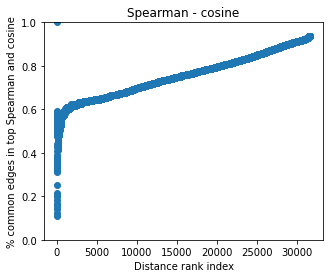

100%|██████████| 31625/31625 [02:34<00:00, 204.64it/s]


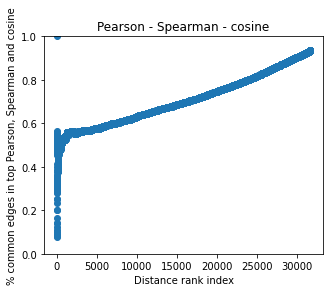

In [19]:
# Plot ROC-type curves for all pairs of distances
rank_thresh_list = np.arange(1,len(all_selected)+1)

# Edge list sorted by Pearson, Spearman and cosine distance
all_selected_pearson = all_selected.sort_values(by='pearson_dist', ascending=True).index.values
all_selected_spearman = all_selected.sort_values(by='spearman_dist', ascending=True).index.values
all_selected_cosine= all_selected.sort_values(by='cosine_dist', ascending=True).index.values

# Spearman and Pearson
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_pearson[:t])
    lowest_dist_2 = set(all_selected_spearman[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Pearson and Spearman')
plt.title('Spearman - Pearson')
plt.show()

# Pearson and cosine
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_pearson[:t])
    lowest_dist_2 = set(all_selected_cosine[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Pearson and cosine')
plt.title('Pearson - cosine')
plt.show()

# Spearman and cosine
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_cosine[:t])
    lowest_dist_2 = set(all_selected_spearman[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Spearman and cosine')
plt.title('Spearman - cosine')
plt.show()

# Spearman, Pearson and cosine
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_pearson[:t])
    lowest_dist_2 = set(all_selected_spearman[:t])
    lowest_dist_3 = set(all_selected_cosine[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2).intersection(lowest_dist_3))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Pearson, Spearman and cosine')
plt.title('Pearson - Spearman - cosine')
plt.show()


## Compare HiC clusters and regulatory clusters

### Get HiC clusters

In [17]:
# Construct network
inter_selected = adhesome_interX_edge_list.copy()
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)
dist_hic = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
np.fill_diagonal(dist_hic,0)
y = dist_hic[np.triu_indices(n=len(dist_hic),k=1)]

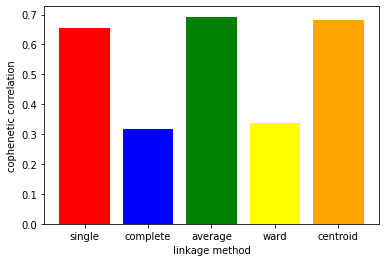

In [18]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_single = cophenet(linkage(y, method='single'), y)[0]
cophenet_complete = cophenet(linkage(y, method='complete'), y)[0]
cophenet_average = cophenet(linkage(y, method='average'), y)[0]
cophenet_ward = cophenet(linkage(y, method='ward'), y)[0]
cophenet_centroid = cophenet(linkage(y, method='centroid'), y)[0]
plt.figure()
plt.bar(x=['single', 'complete', 'average', 'ward', 'centroid'],
        height = [cophenet_single, cophenet_complete, cophenet_average, cophenet_ward, cophenet_centroid],
        color = ['red', 'blue', 'green', 'yellow', 'orange'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
plt.show()

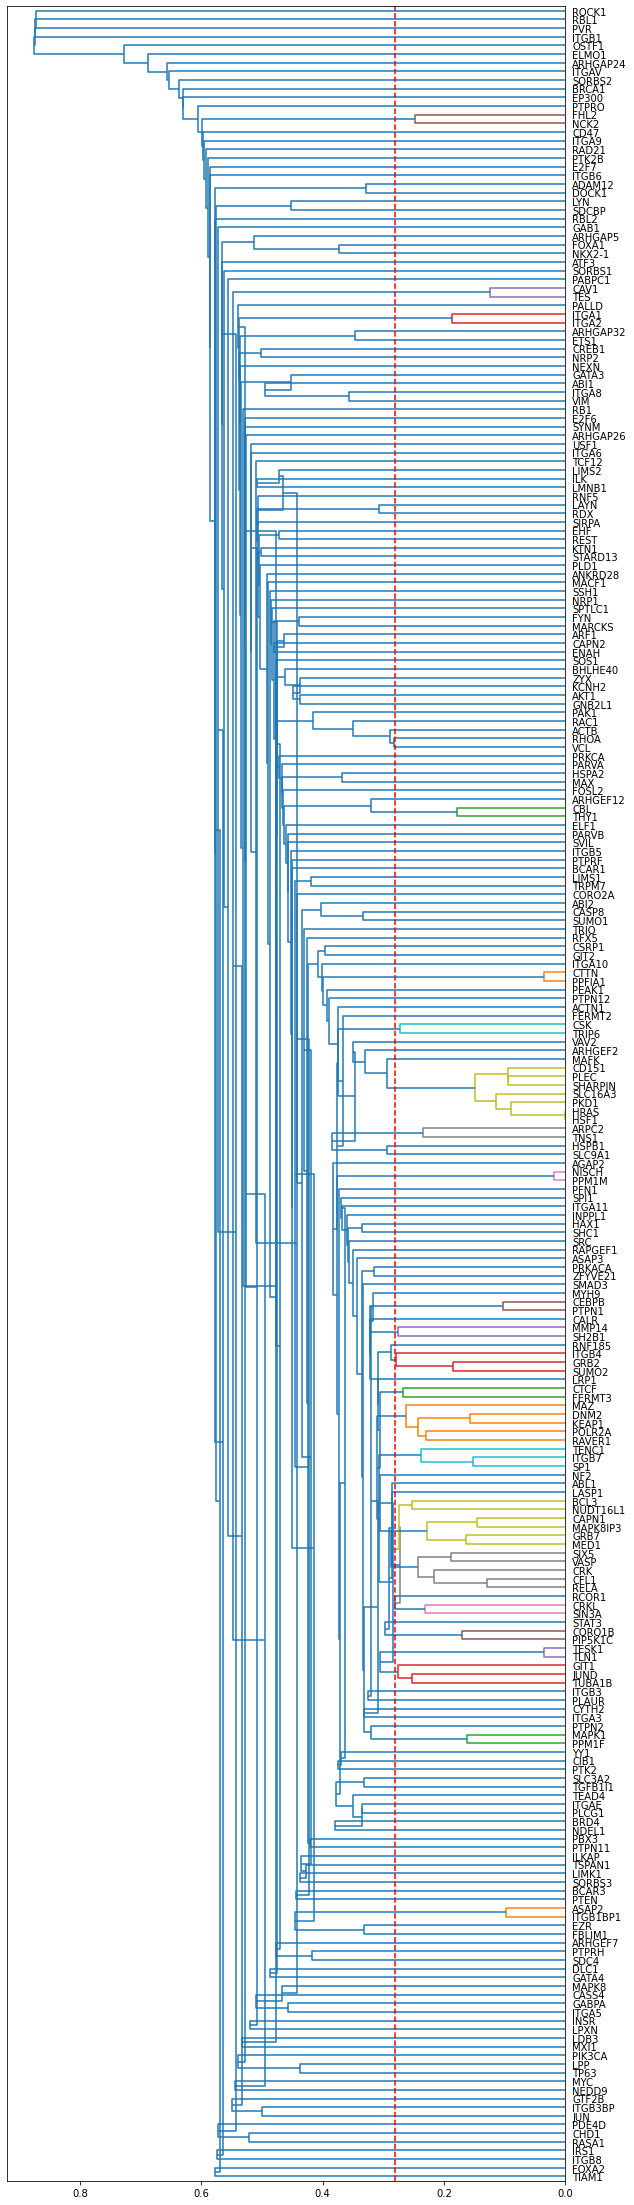

In [19]:
# Perform HC with average linkage
linked1 = linkage(y, method='centroid')
t1 = cc.get_4chrom_clustering(linked1, sorted(G.nodes), gene2chrom)
clust1 = fcluster(linked1, t1, criterion='distance')
plt.figure(figsize=(10, 40))
dendrogram(linked1,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=t1)
plt.vlines(x=t1, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

In [20]:
# Get clustering dataframe
clustering_hic_df = pd.DataFrame({'gene': sorted(G.nodes),
                                  'chrom': [gene2chrom[g] for g in sorted(G.nodes)],
                                  'cluster': clust1})
clustering_hic_df = clustering_hic_df.groupby('cluster').agg({'gene': lambda x: list(x),
                                                              'chrom': lambda x: list(x)})
clustering_hic_df['unique_chrom'] = [set(ls) for ls in clustering_hic_df['chrom']]
clustering_hic_df['size'] = [len(ls) for ls in clustering_hic_df['gene']]
clustering_hic_df1 = clustering_hic_df[clustering_hic_df['size']>1]
clustering_hic_df1 = clustering_hic_df1.sort_values(by='size', ascending=False)
clustering_hic_df1

gene  \
cluster                                                      
102      [CD151, HRAS, HSF1, PKD1, PLEC, SHARPIN, SLC16A3]   
67                           [CFL1, CRK, RELA, SIX5, VASP]   
61                      [DNM2, KEAP1, MAZ, POLR2A, RAVER1]   
66                           [CAPN1, GRB7, MAPK8IP3, MED1]   
62                                     [ITGB7, SP1, TENC1]   
74                                    [GIT1, JUND, TUBA1B]   
58                                    [GRB2, ITGB4, SUMO2]   
63                                           [CRKL, SIN3A]   
106                                          [ARPC2, TNS1]   
101                                           [CSK, TRIP6]   
73                                           [TESK1, TLN1]   
69                                       [CORO1B, PIP5K1C]   
65                                        [BCL3, NUDT16L1]   
1                                             [FHL2, NCK2]   
9                                              [CAV1, TES]   
60                                          [CTCF, FERMT3]   
57                                          [MMP14, SH2B1]   
56                                          [CEBPB, PTPN1]   
54                                          [MAPK1, PPM1F]   
49                                          [NISCH, PPM1M]   
48                                          [CTTN, PPFIA1]   
39                                             [CBL, THY1]   
10                                          [ITGA1, ITGA2]   
125                                      [ASAP2, ITGB1BP1]   

                                                  chrom  \
cluster                                                   
102      [chr11, chr11, chr8, chr16, chr8, chr8, chr17]   
67                  [chr11, chr17, chr11, chr19, chr19]   
61                  [chr19, chr19, chr16, chr17, chr19]   
66                         [chr11, chr17, chr16, chr17]   
62                                [chr12, chr12, chr12]   
74                                [chr17, chr19, chr12]   
58                                [chr17, chr17, chr17]   
63                                       [chr22, chr15]   
106                                        [chr2, chr2]   
101                                       [chr15, chr7]   
73                                         [chr9, chr9]   
69                                       [chr11, chr19]   
65                                       [chr19, chr16]   
1                                          [chr2, chr2]   
9                                          [chr7, chr7]   
60                                       [chr16, chr11]   
57                                       [chr14, chr16]   
56                                       [chr20, chr20]   
54                                       [chr22, chr22]   
49                                         [chr3, chr3]   
48                                       [chr11, chr11]   
39                                       [chr11, chr11]   
10                                         [chr5, chr5]   
125                                        [chr2, chr2]   

                        unique_chrom  size  
cluster                                     
102      {chr16, chr8, chr17, chr11}     7  
67             {chr19, chr17, chr11}     5  
61             {chr16, chr19, chr17}     5  
66             {chr16, chr17, chr11}     4  
62                           {chr12}     3  
74             {chr19, chr12, chr17}     3  
58                           {chr17}     3  
63                    {chr15, chr22}     2  
106                           {chr2}     2  
101                    {chr15, chr7}     2  
73                            {chr9}     2  
69                    {chr19, chr11}     2  
65                    {chr16, chr19}     2  
1                             {chr2}     2  
9                             {chr7}     2  
60                    {chr16, chr11}     2  
57                    {chr14, chr16}     2  
56                           {chr20}     2  
54    

### Get regulatory clusters

In [21]:
# Construct network
inter_selected = adhesome_interX_edge_list.copy()
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)

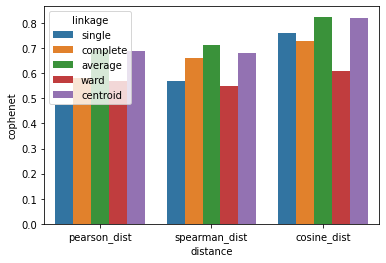

In [22]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_df = pd.DataFrame(columns=['distance', 'linkage', 'cophenet'])

for dist in ['pearson_dist', 'spearman_dist', 'cosine_dist']:
    for link in ['single', 'complete', 'average', 'ward', 'centroid']:
        dist_mat = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight=dist).todense())
        np.fill_diagonal(dist_mat,0)
        y = dist_mat[np.triu_indices(n=len(dist_mat),k=1)]
        cophenet_corr = cophenet(linkage(y, method=link), y)[0]
        cophenet_df = pd.concat([cophenet_df, pd.DataFrame({'distance': [dist], 'linkage': link, 'cophenet':cophenet_corr})], 
                                axis=0)
plt.figure()
sns.barplot(x='distance', y='cophenet', hue='linkage', data=cophenet_df)
plt.show()

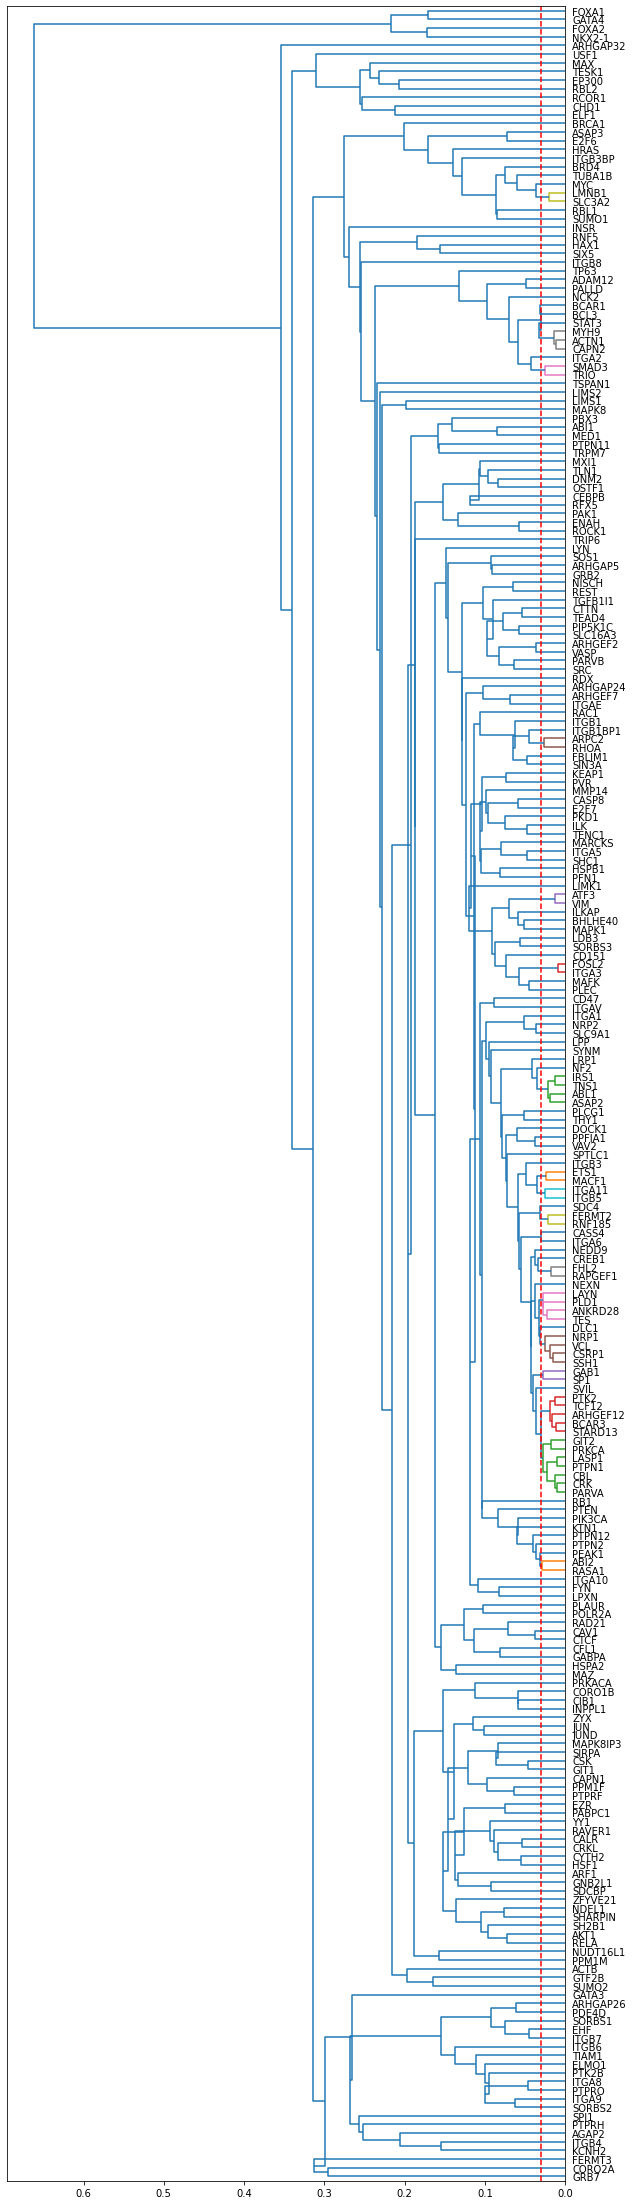

In [23]:
# Cluster using average linkage and cosine distance
dist_mat = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='cosine_dist').todense())
np.fill_diagonal(dist_mat,0)
y = dist_mat[np.triu_indices(n=len(dist_mat),k=1)]
linked2 = linkage(y, method='centroid')
t2 = cc.get_4chrom_clustering(linked2, sorted(G.nodes), gene2chrom, max_chrom=5)
clust2 = fcluster(linked2, t2, criterion='distance')
plt.figure(figsize=(10, 40))
dendrogram(linked2,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=t2)
plt.vlines(x=t2, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

In [24]:
# Get clustering dataframe
clustering_hic_df = pd.DataFrame({'gene': sorted(G.nodes),
                                  'chrom': [gene2chrom[g] for g in sorted(G.nodes)],
                                  'cluster': clust2})
clustering_hic_df = clustering_hic_df.groupby('cluster').agg({'gene': lambda x: list(x),
                                                              'chrom': lambda x: list(x)})
clustering_hic_df['unique_chrom'] = [set(ls) for ls in clustering_hic_df['chrom']]
clustering_hic_df['size'] = [len(ls) for ls in clustering_hic_df['gene']]
clustering_hic_df2 = clustering_hic_df[clustering_hic_df['size']>1]
clustering_hic_df2 = clustering_hic_df2.sort_values(by='size', ascending=False)
clustering_hic_df2

gene  \
cluster                                                 
105      [CBL, CRK, GIT2, LASP1, PARVA, PRKCA, PTPN1]   
104           [ARHGEF12, BCAR3, PTK2, STARD13, TCF12]   
100                          [CSRP1, NRP1, SSH1, VCL]   
81                          [ABL1, ASAP2, IRS1, TNS1]   
99                         [ANKRD28, LAYN, PLD1, TES]   
31                               [ACTN1, CAPN2, MYH9]   
15                                    [LMNB1, SLC3A2]   
134                                       [ATF3, VIM]   
110                                     [ABI2, RASA1]   
103                                       [GAB1, SP1]   
96                                    [FHL2, RAPGEF1]   
92                                   [FERMT2, RNF185]   
90                                    [ITGA11, ITGB5]   
89                                      [ETS1, MACF1]   
70                                      [ARPC2, RHOA]   
33                                      [SMAD3, TRIO]   
140                                    [FOSL2, ITGA3]   

                                                     chrom  \
cluster                                                      
105      [chr11, chr17, chr12, chr17, chr11, chr17, chr20]   
104                      [chr11, chr1, chr8, chr13, chr15]   
100                            [chr1, chr10, chr12, chr10]   
81                                [chr9, chr2, chr2, chr2]   
99                               [chr3, chr11, chr3, chr7]   
31                                    [chr14, chr1, chr22]   
15                                           [chr5, chr11]   
134                                          [chr1, chr10]   
110                                           [chr2, chr5]   
103                                          [chr4, chr12]   
96                                            [chr2, chr9]   
92                                          [chr14, chr22]   
90                                           [chr15, chr3]   
89                                           [chr11, chr1]   
70                                            [chr2, chr3]   
33                                           [chr15, chr5]   
140                                          [chr2, chr17]   

                              unique_chrom  size  
cluster                                           
105           {chr20, chr12, chr17, chr11}     7  
104      {chr1, chr13, chr11, chr15, chr8}     5  
100                   {chr1, chr10, chr12}     4  
81                            {chr9, chr2}     4  
99                     {chr3, chr11, chr7}     4  
31                    {chr14, chr22, chr1}     3  
15                           {chr5, chr11}     2  
134                          {chr1, chr10}     2  
110                           {chr5, chr2}     2  
103                          {chr12, chr4}     2  
96                            {chr9, chr2}     2  
92                          {chr14, chr22}     2  
90                           {chr15, chr3}     2  
89                           {chr1, chr11}     2  
70                            {chr3, chr2}     2  
33                           {chr15, chr5}     2  
140                          {chr2, chr17}     2

# Find clusters of adhesome genes

## Clusters based on HiC

In [62]:
# Construct network
inter_selected = adhesome_interX_edge_list.copy()
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)
dist_hic = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
np.fill_diagonal(dist_hic,0)
y = dist_hic[np.triu_indices(n=len(dist_hic),k=1)]

In [63]:
# Run hierarchical clustering
linked = linkage(y, method='average')
t = cc.get_4chrom_clustering(linked, sorted(G.nodes), gene2chrom)
clust = fcluster(linked, t, criterion='distance')

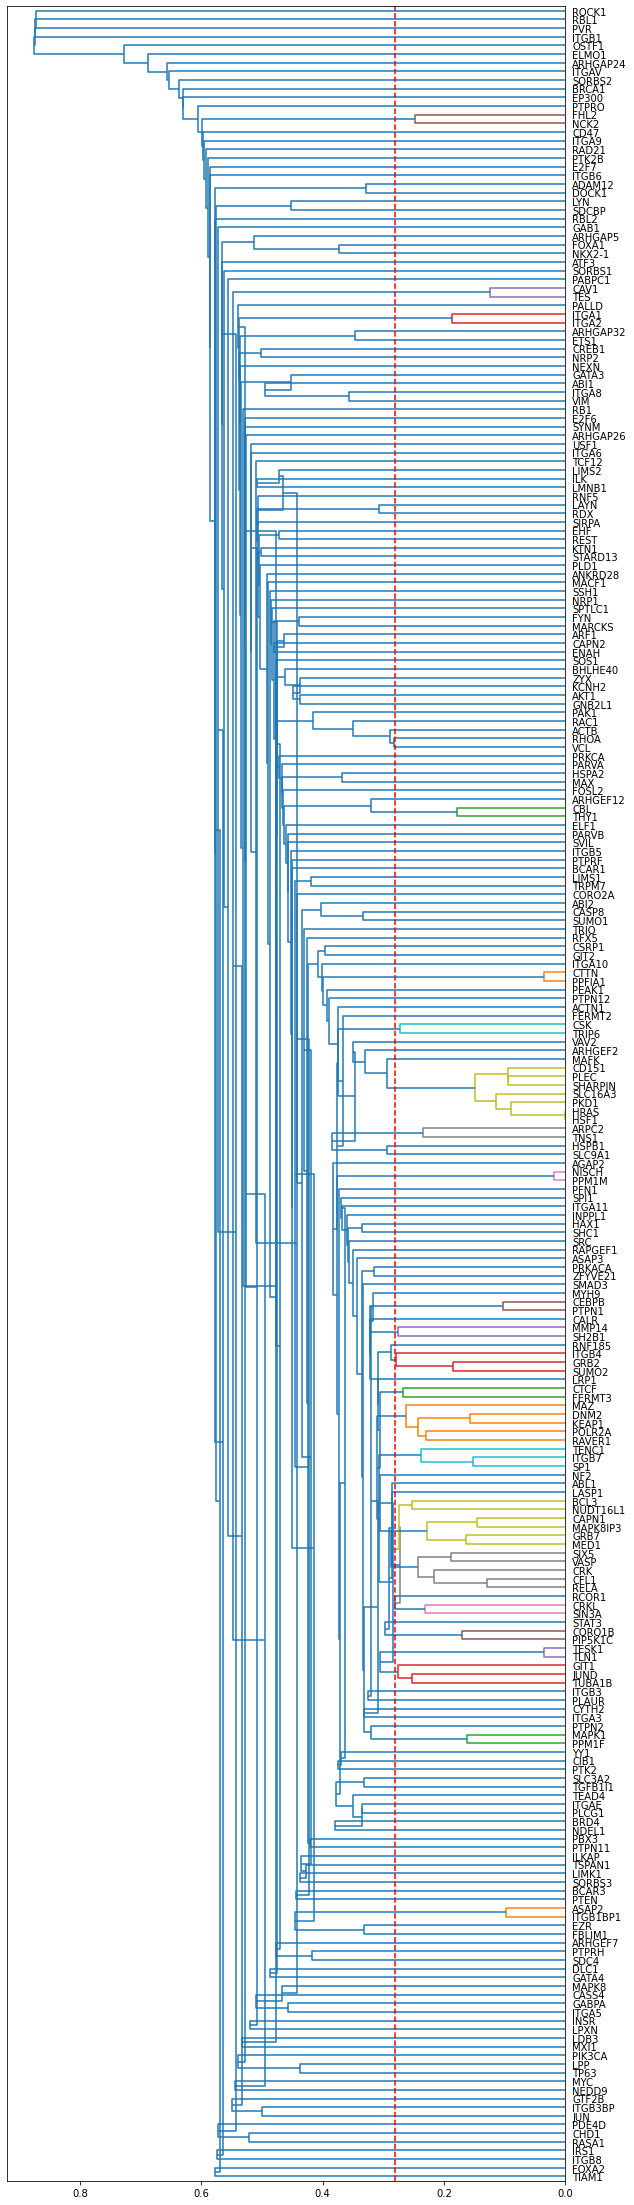

In [64]:
# Plot dendrogram
plt.figure(figsize=(10, 40))
dendrogram(linked1,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=t1)
plt.vlines(x=t1, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

Number of singletons = 187
Number of non-singleton clusters = 24


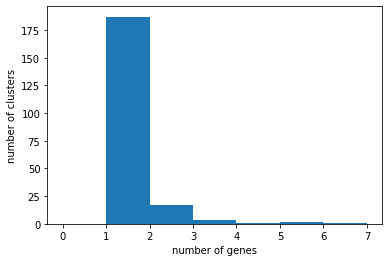

gene  \
cluster                                                      
102      [CD151, HRAS, HSF1, PKD1, PLEC, SHARPIN, SLC16A3]   
67                           [CFL1, CRK, RELA, SIX5, VASP]   
61                      [DNM2, KEAP1, MAZ, POLR2A, RAVER1]   
66                           [CAPN1, GRB7, MAPK8IP3, MED1]   
62                                     [ITGB7, SP1, TENC1]   
74                                    [GIT1, JUND, TUBA1B]   
58                                    [GRB2, ITGB4, SUMO2]   
63                                           [CRKL, SIN3A]   
106                                          [ARPC2, TNS1]   
101                                           [CSK, TRIP6]   
73                                           [TESK1, TLN1]   
69                                       [CORO1B, PIP5K1C]   
65                                        [BCL3, NUDT16L1]   
1                                             [FHL2, NCK2]   
9                                              [CAV1, TES]   
60                                          [CTCF, FERMT3]   
57                                          [MMP14, SH2B1]   
56                                          [CEBPB, PTPN1]   
54                                          [MAPK1, PPM1F]   
49                                          [NISCH, PPM1M]   
48                                          [CTTN, PPFIA1]   
39                                             [CBL, THY1]   
10                                          [ITGA1, ITGA2]   
125                                      [ASAP2, ITGB1BP1]   

                                                  chrom            TFs  \
cluster                                                                  
102      [chr11, chr11, chr8, chr16, chr8, chr8, chr17]         [HSF1]   
67                  [chr11, chr17, chr11, chr19, chr19]   [RELA, SIX5]   
61                  [chr19, chr19, chr16, chr17, chr19]  [MAZ, POLR2A]   
66                         [chr11, chr17, chr16, chr17]         [MED1]   
62                                [chr12, chr12, chr12]          [SP1]   
74                                [chr17, chr19, chr12]         [JUND]   
58                                [chr17, chr17, chr17]        [SUMO2]   
63                                       [chr22, chr15]        [SIN3A]   
106                                        [chr2, chr2]             []   
101                                       [chr15, chr7]             []   
73                                         [chr9, chr9]             []   
69                                       [chr11, chr19]             []   
65                                       [chr19, chr16]         [BCL3]   
1                                          [chr2, chr2]             []   
9                                          [chr7, chr7]             []   
60                                       [chr16, chr11]         [CTCF]   
57                                       [chr14, chr16]             []   
56                                       [chr20, chr20]        [CEBPB]   
54                                       [chr22, chr22]             []   
49                                         [chr3, chr3]             []   
48                                       [chr11, chr11]             []   
39                                       [chr11, chr11]             []   
10                                         [chr5, chr5]             []   
125                                        [chr2, chr2]             []   

                        unique_chrom  size  
cluster                                     
102      {chr16, chr8, chr17, chr11}     7  
67             {chr19, chr17, chr11}     5  
61             {chr16, chr19, chr17}     5  
66             {chr16, chr17, chr11}     4  
62                           {chr12}     3  
74             {chr19, chr12, chr17}     3  
58                           {chr17}     3  
63                    {chr15, chr22}     2  
106                           {chr2}     2  
101                  

In [65]:
# Get clustering dataframe
clustering_hic_df = pd.DataFrame({'gene': sorted(G.nodes),
                                  'chrom': [gene2chrom[g] for g in sorted(G.nodes)],
                                  'cluster': clust1})
clustering_hic_df = clustering_hic_df.groupby('cluster').agg({'gene': lambda x: list(x),
                                                              'chrom': lambda x: list(x)})
clustering_hic_df['TFs'] = [[g for g in clustering_hic_df.iloc[i]['gene'] if g in active_lung_adhesome_tf_genes] 
                            for i in range(len(clustering_hic_df))]
clustering_hic_df['unique_chrom'] = [set(ls) for ls in clustering_hic_df['chrom']]
clustering_hic_df['size'] = [len(ls) for ls in clustering_hic_df['gene']]
print('Number of singletons = '+str(len(clustering_hic_df[clustering_hic_df['size']==1])))
print('Number of non-singleton clusters = '+str(len(clustering_hic_df[clustering_hic_df['size']>1])))
plt.figure()
clustering_hic_df['size'].plot.hist(bins=np.arange(0,8,1))
plt.xlabel('number of genes')
plt.ylabel('number of clusters')
plt.show()
clustering_hic_df = clustering_hic_df[clustering_hic_df['size']>1]
clustering_hic_df = clustering_hic_df.sort_values(by='size', ascending=False)
clustering_hic_df

## Check using regulatory features

In [66]:
# Obtain adjacency matrix based on regulatory features
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)
A = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='spearman_dist').todense())
np.fill_diagonal(A,1)
A = pd.DataFrame(A, index=sorted(G.nodes), columns=sorted(G.nodes))
#y = A[np.triu_indices(n=len(A),k=1)]

In [69]:
# Compute regulatory strength of each cluster
reg_strength = []
for c in clustering_hic_df.index:
    genes = clustering_hic_df.loc[c,'gene']
    reg_strength.append(np.mean(A.loc[genes,genes].values[np.triu_indices(n=len(genes), k=1)]))
clustering_hic_df['reg_strength'] = reg_strength
clustering_hic_df

gene  \
cluster                                                      
102      [CD151, HRAS, HSF1, PKD1, PLEC, SHARPIN, SLC16A3]   
67                           [CFL1, CRK, RELA, SIX5, VASP]   
61                      [DNM2, KEAP1, MAZ, POLR2A, RAVER1]   
66                           [CAPN1, GRB7, MAPK8IP3, MED1]   
62                                     [ITGB7, SP1, TENC1]   
74                                    [GIT1, JUND, TUBA1B]   
58                                    [GRB2, ITGB4, SUMO2]   
63                                           [CRKL, SIN3A]   
106                                          [ARPC2, TNS1]   
101                                           [CSK, TRIP6]   
73                                           [TESK1, TLN1]   
69                                       [CORO1B, PIP5K1C]   
65                                        [BCL3, NUDT16L1]   
1                                             [FHL2, NCK2]   
9                                              [CAV1, TES]   
60                                          [CTCF, FERMT3]   
57                                          [MMP14, SH2B1]   
56                                          [CEBPB, PTPN1]   
54                                          [MAPK1, PPM1F]   
49                                          [NISCH, PPM1M]   
48                                          [CTTN, PPFIA1]   
39                                             [CBL, THY1]   
10                                          [ITGA1, ITGA2]   
125                                      [ASAP2, ITGB1BP1]   

                                                  chrom            TFs  \
cluster                                                                  
102      [chr11, chr11, chr8, chr16, chr8, chr8, chr17]         [HSF1]   
67                  [chr11, chr17, chr11, chr19, chr19]   [RELA, SIX5]   
61                  [chr19, chr19, chr16, chr17, chr19]  [MAZ, POLR2A]   
66                         [chr11, chr17, chr16, chr17]         [MED1]   
62                                [chr12, chr12, chr12]          [SP1]   
74                                [chr17, chr19, chr12]         [JUND]   
58                                [chr17, chr17, chr17]        [SUMO2]   
63                                       [chr22, chr15]        [SIN3A]   
106                                        [chr2, chr2]             []   
101                                       [chr15, chr7]             []   
73                                         [chr9, chr9]             []   
69                                       [chr11, chr19]             []   
65                                       [chr19, chr16]         [BCL3]   
1                                          [chr2, chr2]             []   
9                                          [chr7, chr7]             []   
60                                       [chr16, chr11]         [CTCF]   
57                                       [chr14, chr16]             []   
56                                       [chr20, chr20]        [CEBPB]   
54                                       [chr22, chr22]             []   
49                                         [chr3, chr3]             []   
48                                       [chr11, chr11]             []   
39                                       [chr11, chr11]             []   
10                                         [chr5, chr5]             []   
125                                        [chr2, chr2]             []   

                        unique_chrom  size  reg_strength  
cluster                                                   
102      {chr16, chr8, chr17, chr11}     7      0.686263  
67             {chr19, chr17, chr11}     5      0.606991  
61             {chr16, chr19, chr17}     5      0.628316  
66             {chr16, chr17, chr11}     4      0.491469  
62                           {chr12}     3      0.678463  
74             {chr19, chr12, chr17}     3      0.600937  
58                           {chr17}     3  

100%|██████████| 10000/10000 [00:15<00:00, 628.69it/s]


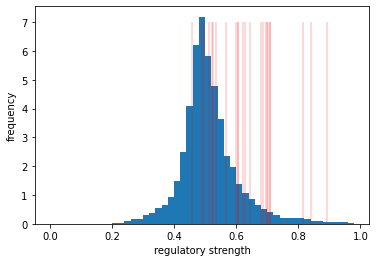

In [75]:
# Derive a null distribution for regulatory strength of clusters
reg_strength_null = []
np.random.seed(13)
for _ in tqdm(range(10000)):
    # Sample number of genes in cluster
    n_genes = np.random.randint(2,7)
    # Sample random active genes
    random_genes = np.random.choice(all_active_genes, size=n_genes, replace=False)
    # Compute regulatory strength
    df_random = df_all_norm.loc[:,random_genes]
    df_random_corr = (1+df_random.corr(method='spearman'))/2
    reg_strength_null.append(np.mean(df_random_corr.values[np.triu_indices(n=len(random_genes), k=1)]))
reg_strength_null = np.array(reg_strength_null)
plt.figure()
plt.hist(reg_strength_null, bins=np.arange(0,1,0.02), density=True)
for s in clustering_hic_df['reg_strength']:
    plt.vlines(x=s, ymin=0, ymax=7, color='red', alpha=0.2)
plt.xlabel('regulatory strength')
plt.ylabel('frequency')
plt.show()

In [73]:
# Compute regulatory p-value for each cluster
clustering_hic_df['pval'] = [np.mean(reg_strength_null>s) for s in clustering_hic_df['reg_strength']]
clustering_hic_df

gene  \
cluster                                                      
102      [CD151, HRAS, HSF1, PKD1, PLEC, SHARPIN, SLC16A3]   
67                           [CFL1, CRK, RELA, SIX5, VASP]   
61                      [DNM2, KEAP1, MAZ, POLR2A, RAVER1]   
66                           [CAPN1, GRB7, MAPK8IP3, MED1]   
62                                     [ITGB7, SP1, TENC1]   
74                                    [GIT1, JUND, TUBA1B]   
58                                    [GRB2, ITGB4, SUMO2]   
63                                           [CRKL, SIN3A]   
106                                          [ARPC2, TNS1]   
101                                           [CSK, TRIP6]   
73                                           [TESK1, TLN1]   
69                                       [CORO1B, PIP5K1C]   
65                                        [BCL3, NUDT16L1]   
1                                             [FHL2, NCK2]   
9                                              [CAV1, TES]   
60                                          [CTCF, FERMT3]   
57                                          [MMP14, SH2B1]   
56                                          [CEBPB, PTPN1]   
54                                          [MAPK1, PPM1F]   
49                                          [NISCH, PPM1M]   
48                                          [CTTN, PPFIA1]   
39                                             [CBL, THY1]   
10                                          [ITGA1, ITGA2]   
125                                      [ASAP2, ITGB1BP1]   

                                                  chrom            TFs  \
cluster                                                                  
102      [chr11, chr11, chr8, chr16, chr8, chr8, chr17]         [HSF1]   
67                  [chr11, chr17, chr11, chr19, chr19]   [RELA, SIX5]   
61                  [chr19, chr19, chr16, chr17, chr19]  [MAZ, POLR2A]   
66                         [chr11, chr17, chr16, chr17]         [MED1]   
62                                [chr12, chr12, chr12]          [SP1]   
74                                [chr17, chr19, chr12]         [JUND]   
58                                [chr17, chr17, chr17]        [SUMO2]   
63                                       [chr22, chr15]        [SIN3A]   
106                                        [chr2, chr2]             []   
101                                       [chr15, chr7]             []   
73                                         [chr9, chr9]             []   
69                                       [chr11, chr19]             []   
65                                       [chr19, chr16]         [BCL3]   
1                                          [chr2, chr2]             []   
9                                          [chr7, chr7]             []   
60                                       [chr16, chr11]         [CTCF]   
57                                       [chr14, chr16]             []   
56                                       [chr20, chr20]        [CEBPB]   
54                                       [chr22, chr22]             []   
49                                         [chr3, chr3]             []   
48                                       [chr11, chr11]             []   
39                                       [chr11, chr11]             []   
10                                         [chr5, chr5]             []   
125                                        [chr2, chr2]             []   

                        unique_chrom  size  reg_strength    pval  
cluster                                                           
102      {chr16, chr8, chr17, chr11}     7      0.686263  0.0526  
67             {chr19, chr17, chr11}     5      0.606991  0.1243  
61             {chr16, chr19, chr17}     5      0.628316  0.0990  
66             {chr16, chr17, chr11}     4      0.491469  0.5668  
62                           {chr12}     3      0.678463  0.0566  
74             {chr19, chr12, chr17}     3     

In [76]:
# Select clusters that show string coregulation
pval_threshold = 0.15
clustering_hic_df = clustering_hic_df[clustering_hic_df['pval']<0.15]
clustering_hic_df

gene  \
cluster                                                      
102      [CD151, HRAS, HSF1, PKD1, PLEC, SHARPIN, SLC16A3]   
67                           [CFL1, CRK, RELA, SIX5, VASP]   
61                      [DNM2, KEAP1, MAZ, POLR2A, RAVER1]   
62                                     [ITGB7, SP1, TENC1]   
74                                    [GIT1, JUND, TUBA1B]   
63                                           [CRKL, SIN3A]   
106                                          [ARPC2, TNS1]   
1                                             [FHL2, NCK2]   
9                                              [CAV1, TES]   
57                                          [MMP14, SH2B1]   
54                                          [MAPK1, PPM1F]   
49                                          [NISCH, PPM1M]   
48                                          [CTTN, PPFIA1]   
39                                             [CBL, THY1]   
10                                          [ITGA1, ITGA2]   
125                                      [ASAP2, ITGB1BP1]   

                                                  chrom            TFs  \
cluster                                                                  
102      [chr11, chr11, chr8, chr16, chr8, chr8, chr17]         [HSF1]   
67                  [chr11, chr17, chr11, chr19, chr19]   [RELA, SIX5]   
61                  [chr19, chr19, chr16, chr17, chr19]  [MAZ, POLR2A]   
62                                [chr12, chr12, chr12]          [SP1]   
74                                [chr17, chr19, chr12]         [JUND]   
63                                       [chr22, chr15]        [SIN3A]   
106                                        [chr2, chr2]             []   
1                                          [chr2, chr2]             []   
9                                          [chr7, chr7]             []   
57                                       [chr14, chr16]             []   
54                                       [chr22, chr22]             []   
49                                         [chr3, chr3]             []   
48                                       [chr11, chr11]             []   
39                                       [chr11, chr11]             []   
10                                         [chr5, chr5]             []   
125                                        [chr2, chr2]             []   

                        unique_chrom  size  reg_strength    pval  
cluster                                                           
102      {chr16, chr8, chr17, chr11}     7      0.686263  0.0526  
67             {chr19, chr17, chr11}     5      0.606991  0.1243  
61             {chr16, chr19, chr17}     5      0.628316  0.0990  
62                           {chr12}     3      0.678463  0.0566  
74             {chr19, chr12, chr17}     3      0.600937  0.1331  
63                    {chr15, chr22}     2      0.697188  0.0469  
106                           {chr2}     2      0.606057  0.1257  
1                             {chr2}     2      0.708152  0.0424  
9                             {chr7}     2      0.891392  0.0067  
57                    {chr14, chr16}     2      0.621960  0.1053  
54                           {chr22}     2      0.702942  0.0444  
49                            {chr3}     2      0.645897  0.0807  
48                           {chr11}     2      0.816218  0.0158  
39                           {chr11}     2      0.700391  0.0451  
10                            {chr5}     2      0.840480  0.0112  
125                           {chr2}     2      0.709129  0.0420

### Compare clusterings

INFO  : Finished optimising at entanglement 0.41 (tanglegram2)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram2)


<Figure size 432x288 with 0 Axes>

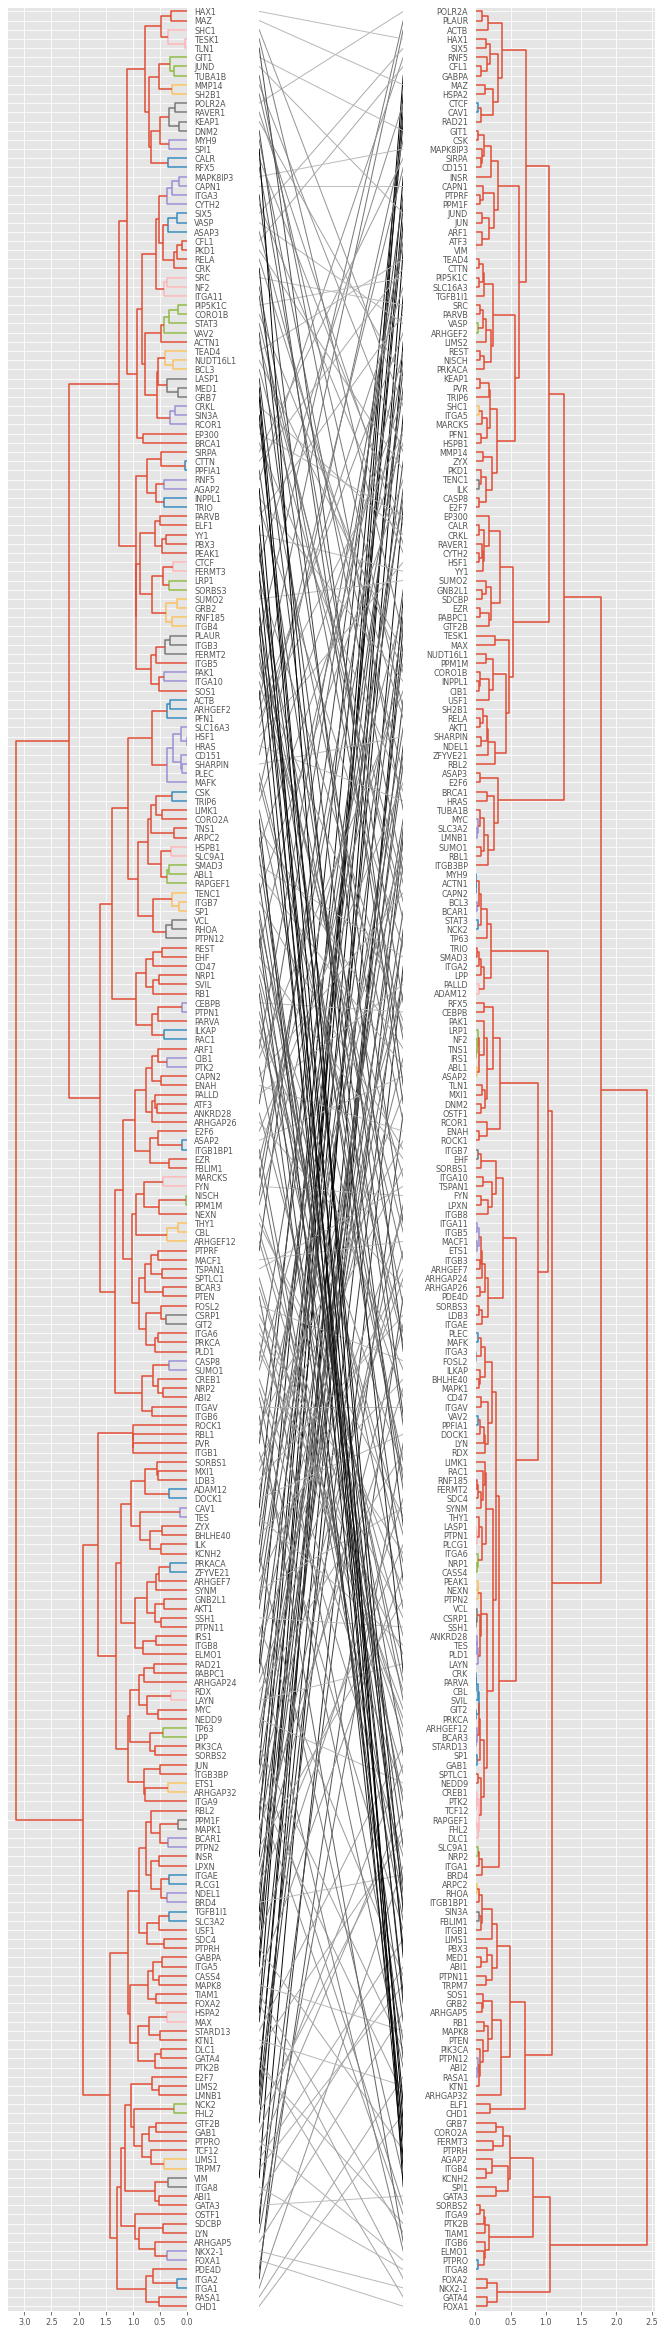

In [109]:
# Compare dendrograms with tanglegram
plt.figure()
tg.plot(a=linked1, b=linked2,
        labelsA=sorted(G.nodes), labelsB=sorted(G.nodes),
        sort="step2side", 
        color_by_diff=True, t1=t1, t2=t2, figsize=(10,40))
plt.show()

## Choose HiC threshold

100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


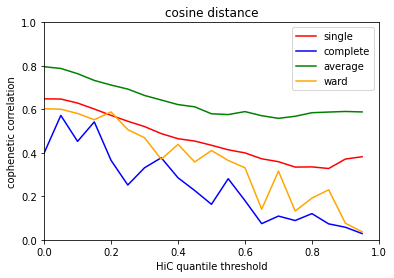

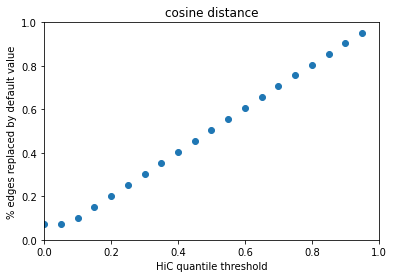

In [110]:
# Cophenetic score for Pearson distance
distance = 'cosine'
hic_threshold_list = np.arange(0., 1, 0.05)
cophenet_single = []
cophenet_complete = []
cophenet_average = []
cophenet_ward = []
pct_edges_replaced = []

# Compute clusterings
for hic_threshold in tqdm(hic_threshold_list):
    # Construct network
    inter_selected = adhesome_interX_edge_list.copy()
    intra_selected = adhesome_intraX_edge_list.copy()
    t = np.quantile(inter_selected['scaled_hic'],hic_threshold)
    u = np.quantile(intra_selected['scaled_hic'],hic_threshold)
    inter_selected['thresholded_hic'] = (inter_selected['scaled_hic']>t).astype(int)
    intra_selected['thresholded_hic'] = (intra_selected['scaled_hic']>u).astype(int)
    intra_selected = intra_selected[['source','target','hic','scaled_hic', 'thresholded_hic',
                                     'pearson_dist','spearman_dist',
                                     'cosine_dist']]
    adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
    G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic', 'thresholded_hic',
                                                               'pearson_dist','spearman_dist',
                                                               'cosine_dist'])
    G.add_nodes_from(selected_genes)
    A_hic = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='thresholded_hic').todense()>0)
    np.fill_diagonal(A_hic, 1)
    A = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight=distance+'_dist').todense())
    # A[A_hic==0] = 1
    A[A_hic==0] = 0.5
    np.fill_diagonal(A,0)
    # Compute percentage of edges that were replaced
    pct_edges_replaced.append(len(np.where(~A_hic)[0])/(len(A_hic)*(len(A_hic)-1)))
    # Compute dendrogram
    y = A[np.triu_indices(n=len(A),k=1)]
    cophenet_single.append(cophenet(linkage(y, method='single'), y)[0])
    cophenet_complete.append(cophenet(linkage(y, method='complete'), y)[0])
    cophenet_average.append(cophenet(linkage(y, method='average'), y)[0])
    cophenet_ward.append(cophenet(linkage(y, method='ward'), y)[0])

# Plot
plt.figure()
plt.plot(hic_threshold_list, cophenet_single, color='red', label='single')
plt.plot(hic_threshold_list, cophenet_complete, color='blue', label='complete')
plt.plot(hic_threshold_list, cophenet_average, color='green', label='average')
plt.plot(hic_threshold_list, cophenet_ward, color='orange', label='ward')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('HiC quantile threshold')
plt.ylabel('cophenetic correlation')
plt.legend(loc='upper right')
plt.title(distance+' distance')
plt.show()

# Percentage of edges replaced by default value
plt.figure()
plt.scatter(hic_threshold_list, pct_edges_replaced)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('HiC quantile threshold')
plt.ylabel('% edges replaced by default value')
plt.title(distance+' distance')
plt.show()


In [316]:
# Silhouette
distance = 'cosine'
hic_threshold_list = np.arange(0., 1, 0.05)
cluster_df = pd.DataFrame({'gene': sorted(selected_genes)})
singleton_df = pd.DataFrame({'gene': sorted(selected_genes)})
silhouette_df = pd.DataFrame({'gene': sorted(selected_genes)})

# Compute clusterings
for hic_threshold in tqdm(hic_threshold_list):
    # Construct network
    inter_selected = adhesome_interX_edge_list.copy()
    intra_selected = adhesome_intraX_edge_list.copy()
    t = np.quantile(inter_selected['scaled_hic'],hic_threshold)
    u = np.quantile(intra_selected['scaled_hic'],hic_threshold)
    inter_selected['thresholded_hic'] = (inter_selected['scaled_hic']>t).astype(int)
    intra_selected['thresholded_hic'] = (intra_selected['scaled_hic']>u).astype(int)
    intra_selected = intra_selected[['source','target','hic','scaled_hic', 'thresholded_hic',
                                     'pearson_dist','spearman_dist',
                                     'cosine_dist']]
    adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
    G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic', 'thresholded_hic',
                                                               'pearson_dist','spearman_dist',
                                                               'cosine_dist'])
    G.add_nodes_from(selected_genes)
    A_hic = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='thresholded_hic').todense()>0)
    np.fill_diagonal(A_hic, 1)
    A = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight=distance+'_dist').todense())
    A[A_hic==0] = 1
    np.fill_diagonal(A,0)
    y = A[np.triu_indices(n=len(A),k=1)]
    
    # Compute average dendrogram
    linked = linkage(y, method='average')
    # Obtain clustering
    t = cc.get_4chrom_clustering(linked, sorted(G.nodes), gene2chrom)
    clust = fcluster(linked, t, criterion='distance')
    clust2singleton = pd.DataFrame({'clust': clust})['clust'].value_counts()
    # Compute silouhette coefficient for every sample
    silhouettes = silhouette_samples(A, labels=clust, metric='precomputed')
    # Summarize information in a dataframe
    cluster_df = pd.concat([cluster_df, pd.DataFrame({'cluster_'+str(hic_threshold): clust})],
                           axis=1)
    singleton_df = pd.concat([singleton_df, pd.DataFrame({hic_threshold: [clust2singleton[c] for c in clust]})],
                              axis=1)
    silhouette_df =  pd.concat([silhouette_df, pd.DataFrame({hic_threshold: silhouettes})],
                                axis=1)
cluster_df = cluster_df.set_index('gene')
singleton_df = singleton_df.set_index('gene')
singleton_df['avg_singleton'] = singleton_df.mean(axis=1)
silhouette_df = silhouette_df.set_index('gene')
silhouette_df['avg_silhouette'] = silhouette_df.mean(axis=1)

100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


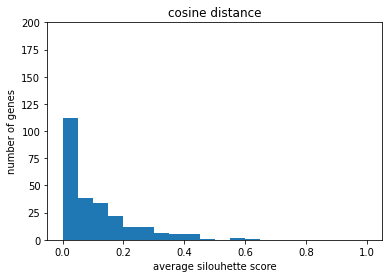

In [317]:
# Distribution of average silhouette scores
threshold = 0.3
plt.figure()
plt.hist(silhouette_df['avg_silhouette'].values, bins=np.arange(0, 1.05, 0.05))
#plt.vlines(x=threshold, ymin=0, ymax=100, color='red', linestyle='dashed')
plt.ylim(0,200)
plt.xlabel('average silouhette score')
plt.ylabel('number of genes')
plt.title(distance+' distance')
plt.show()
selected_silhouette = silhouette_df[silhouette_df['avg_silhouette']>threshold].iloc[:,:-1]

<Figure size 432x288 with 0 Axes>

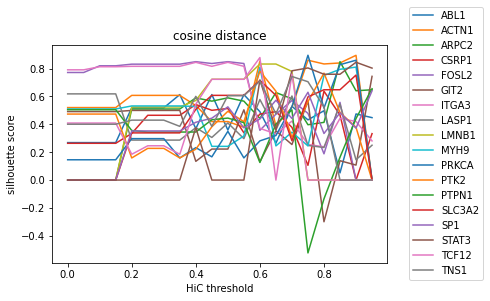

In [295]:
# Plot silhouette score of nodes
plt.figure()
selected_silhouette.T.plot()
plt.legend(bbox_to_anchor=[1.05, 1.2])
plt.xlabel('HiC threshold')
plt.ylabel('silhouette score')
plt.title(distance+' distance')
plt.show()

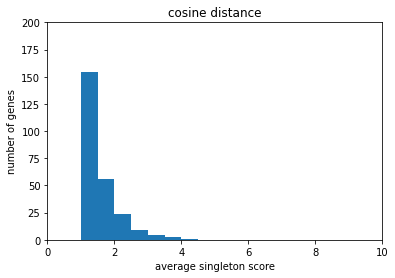

In [318]:
# Distribution of average singleton scores
threshold = 2.5
plt.figure()
plt.hist(singleton_df['avg_singleton'].values, bins=np.arange(0,10,0.5))
#plt.vlines(x=threshold, ymin=0, ymax=100, color='red', linestyle='dashed')
plt.title(distance+' distance')
plt.xlim(0,10)
plt.ylim(0,200)
plt.xlabel('average singleton score')
plt.ylabel('number of genes')
plt.show()
selected_singleton = singleton_df[singleton_df['avg_singleton']>threshold].iloc[:,:-1]

<Figure size 432x288 with 0 Axes>

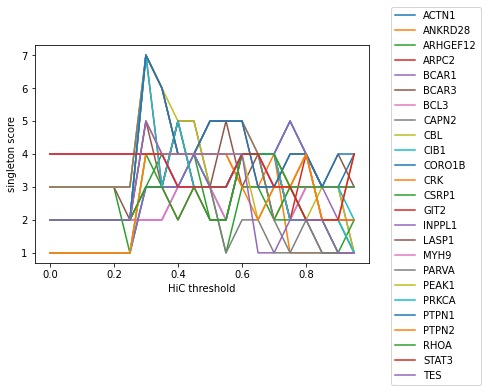

In [289]:
# Plot singleton score of nodes
plt.figure()
selected_singleton.T.plot()
plt.legend(bbox_to_anchor=[1.05, 1.2])
plt.xlabel('HiC threshold')
plt.ylabel('singleton score')
plt.show()

### Choose interpolation between HiC and epigenomic features

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


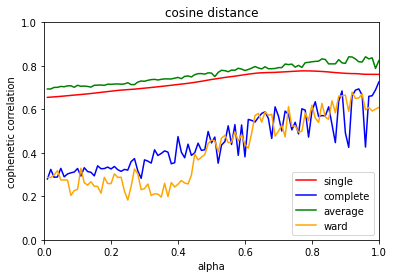

In [17]:
# Cophenetic score for Pearson distance
alpha_list = np.arange(0.01, 1.01, 0.01)
cophenet_single = []
cophenet_complete = []
cophenet_average = []
cophenet_ward = []

# Compute clusterings
for alpha in tqdm(alpha_list):
    # Construct network
    inter_selected = adhesome_interX_edge_list.copy()
    intra_selected = adhesome_intraX_edge_list.copy()
    intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                     'pearson_dist','spearman_dist',
                                     'cosine_dist']]
    adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)  
    G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                               'pearson_dist','spearman_dist',
                                                               'cosine_dist'])
    G.add_nodes_from(selected_genes)
    A1 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='cosine_dist')
    A2 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic')
    A = alpha*np.array(A1.todense())+(1-alpha)*(1-np.array(A2.todense()))
    np.fill_diagonal(A,0)
    # Compute dendrogram
    y = A[np.triu_indices(n=len(A),k=1)]
    cophenet_single.append(cophenet(linkage(y, method='single'), y)[0])
    cophenet_complete.append(cophenet(linkage(y, method='complete'), y)[0])
    cophenet_average.append(cophenet(linkage(y, method='average'), y)[0])
    cophenet_ward.append(cophenet(linkage(y, method='ward'), y)[0])

# Plot
plt.figure()
plt.plot(alpha_list, cophenet_single, color='red', label='single')
plt.plot(alpha_list, cophenet_complete, color='blue', label='complete')
plt.plot(alpha_list, cophenet_average, color='green', label='average')
plt.plot(alpha_list, cophenet_ward, color='orange', label='ward')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('alpha')
plt.ylabel('cophenetic correlation')
plt.legend(loc='lower right')
plt.title('cosine distance')
plt.show()

In [44]:
# Cophenetic score for Pearson distance
distance = 'spearman'
alpha_list = np.arange(0.01, 1.01, 0.01)
cluster_df = pd.DataFrame({'gene': sorted(selected_genes)})
singleton_df = pd.DataFrame({'gene': sorted(selected_genes)})
silhouette_df = pd.DataFrame({'gene': sorted(selected_genes)})

# Compute clusterings
for alpha in tqdm(alpha_list):
    alpha=0.7
    # Construct network
    inter_selected = adhesome_interX_edge_list.copy()
    intra_selected = adhesome_intraX_edge_list.copy()
    intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                     'pearson_dist','spearman_dist',
                                     'cosine_dist']]
    adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)  
    G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                               'pearson_dist','spearman_dist',
                                                               'cosine_dist'])
    G.add_nodes_from(selected_genes)
    A1 = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight=distance+'_dist').todense())
    A2 = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
    A = alpha*A1+(1-alpha)*A2
    np.fill_diagonal(A,0)
    
    # Compute average dendrogram
    linked = linkage(y, method='average')
    # Obtain clustering
    t = cc.get_4chrom_clustering(linked, sorted(G.nodes), gene2chrom, max_chrom=5)
    clust = fcluster(linked, t, criterion='distance')
    clust2singleton = pd.DataFrame({'clust': clust})['clust'].value_counts()
    # Compute silouhette coefficient for every sample
    silhouettes = silhouette_samples(A, labels=clust, metric='precomputed')
    # Summarize information in a dataframe
    cluster_df = pd.concat([cluster_df, pd.DataFrame({'cluster_'+str(hic_threshold): clust})],
                           axis=1)
    singleton_df = pd.concat([singleton_df, pd.DataFrame({hic_threshold: [clust2singleton[c] for c in clust]})],
                              axis=1)
    silhouette_df =  pd.concat([silhouette_df, pd.DataFrame({hic_threshold: silhouettes})],
                                axis=1)
    break
cluster_df = cluster_df.set_index('gene')
singleton_df = singleton_df.set_index('gene')
singleton_df['avg_singleton'] = singleton_df.mean(axis=1)
silhouette_df = silhouette_df.set_index('gene')
silhouette_df['avg_silhouette'] = silhouette_df.mean(axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]


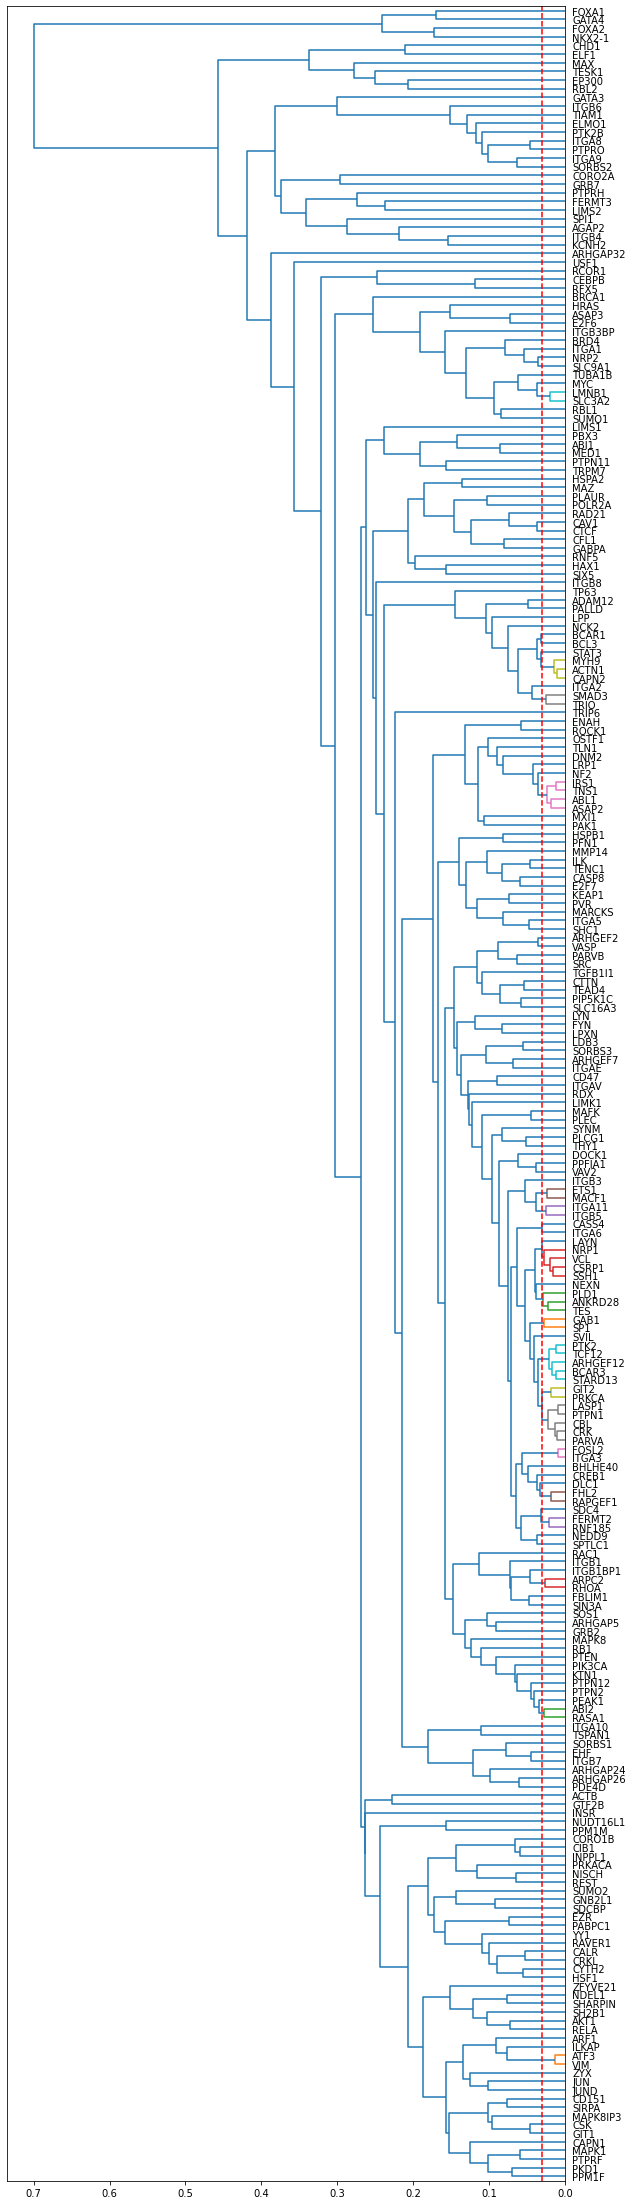

In [45]:
plt.figure(figsize=(10, 40))
dendrogram(linked,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=t)
plt.vlines(x=t, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

In [61]:
np.unique(fcluster(linked, 0.8, criterion='inconsistent'), return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112], dtype=int32),
 array([ 2,  2,  2,  4,  2,  2,  1,  1,  1,  1,  1,  2,  3,  4,  3,  3,  4,
         4,  2,  1,  1,  3,  2,  1,  2,  2,  3,  2,  3,  2,  2,  4,  3,  1,
         1,  1,  2,  2,  2,  1,  1,  1,  1,  1,  2,  2,  2,  2,  1,  2,  3,
         2,  2,  2,  2,  1,  3,  2,  2,  2,  2,  3,  3,  2,  2,  1,  2,  9,
         2,  2,  3,  2,  2,  3,  1,  7,  3,  2,  

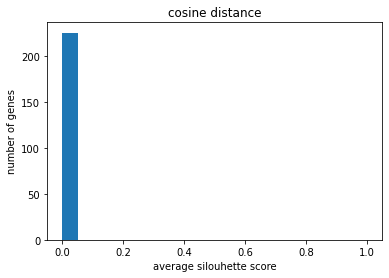

In [23]:
# Distribution of average silhouette scores
threshold = -10
plt.figure()
plt.hist(silhouette_df['avg_silhouette'].values, bins=np.arange(0, 1.05, 0.05))
#plt.vlines(x=threshold, ymin=0, ymax=100, color='red', linestyle='dashed')
plt.xlabel('average silouhette score')
plt.ylabel('number of genes')
plt.title(distance+' distance')
plt.show()
selected_silhouette = silhouette_df[silhouette_df['avg_silhouette']>threshold].iloc[:,:-1]

<Figure size 432x288 with 0 Axes>

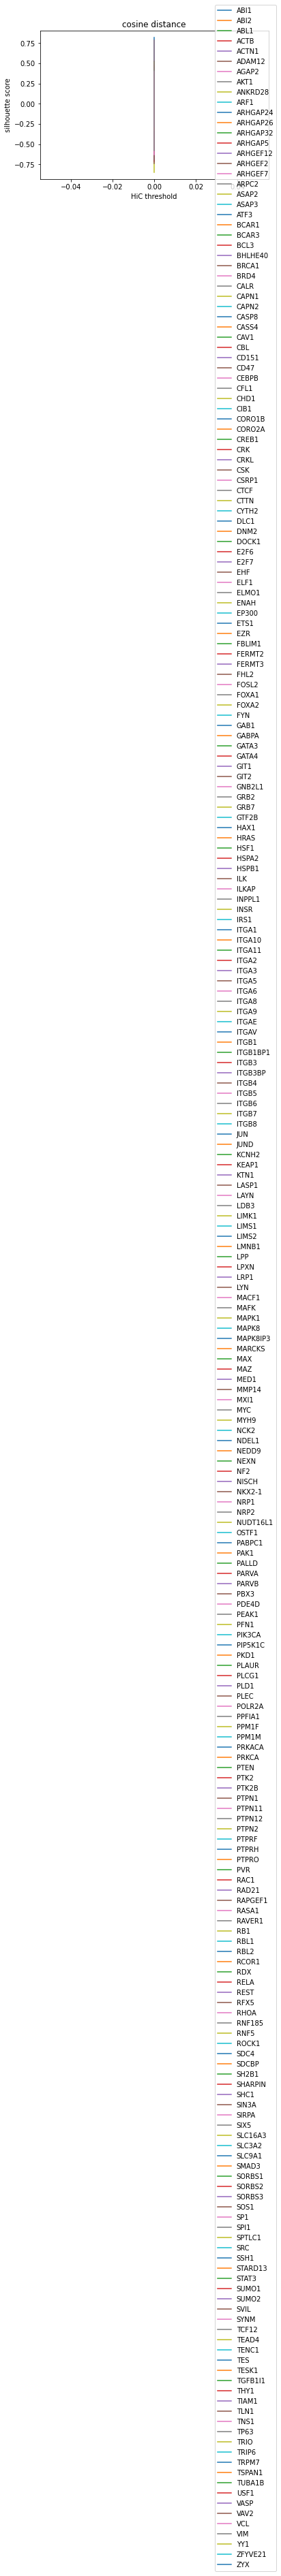

In [24]:
# Plot silhouette score of nodes
plt.figure()
selected_silhouette.T.plot()
plt.legend(bbox_to_anchor=[1.05, 1.2])
plt.xlabel('HiC threshold')
plt.ylabel('silhouette score')
plt.title(distance+' distance')
plt.show()

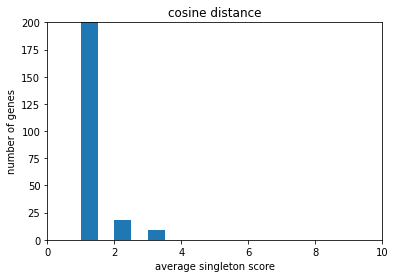

In [25]:
# Distribution of average singleton scores
threshold = 2.5
plt.figure()
plt.hist(singleton_df['avg_singleton'].values, bins=np.arange(0,10,0.5))
#plt.vlines(x=threshold, ymin=0, ymax=100, color='red', linestyle='dashed')
plt.title(distance+' distance')
plt.xlim(0,10)
plt.ylim(0,200)
plt.xlabel('average singleton score')
plt.ylabel('number of genes')
plt.show()
selected_singleton = singleton_df[singleton_df['avg_singleton']>threshold].iloc[:,:-1]

In [ ]:
# Plot singleton score of nodes
plt.figure()
selected_singleton.T.plot()
plt.legend(bbox_to_anchor=[1.05, 1.2])
plt.xlabel('HiC threshold')
plt.ylabel('singleton score')
plt.show()

### Compare dendrograms with tanglegram

In [118]:
alpha_1 = 0.5
alpha_2 = 0.7

In [119]:
# Generate dendrograms for alpha_1
alpha = alpha_1
inter_selected = adhesome_interX_edge_list
intra_selected = adhesome_intraX_edge_list
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(active_adhesome_genes)
A1 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='spearman_dist')
A2 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic')
A = alpha*np.array(A1.todense())+(1-alpha)*(1-np.array(A2.todense()))
np.fill_diagonal(A,0)
y = A[np.triu_indices(n=len(A),k=1)]
link1 = linkage(y, method='average')
t1 = cc.get_4chrom_clustering(link1, sorted(G.nodes), gene2chrom, max_chrom=4)

In [120]:
# Generate dendrograms for alpha_2
alpha = alpha_2
inter_selected = adhesome_interX_edge_list
intra_selected = adhesome_intraX_edge_list
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(active_adhesome_genes)
A1 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='spearman_dist')
A2 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic')
A = alpha*np.array(A1.todense())+(1-alpha)*(1-np.array(A2.todense()))
np.fill_diagonal(A,0)
y = A[np.triu_indices(n=len(A),k=1)]
link2 = linkage(y, method='average')
t2 = cc.get_4chrom_clustering(link2, sorted(G.nodes), gene2chrom, max_chrom=4)

INFO  : Finished optimising at entanglement 0.15 (tanglegram2)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram2)


<Figure size 432x288 with 0 Axes>

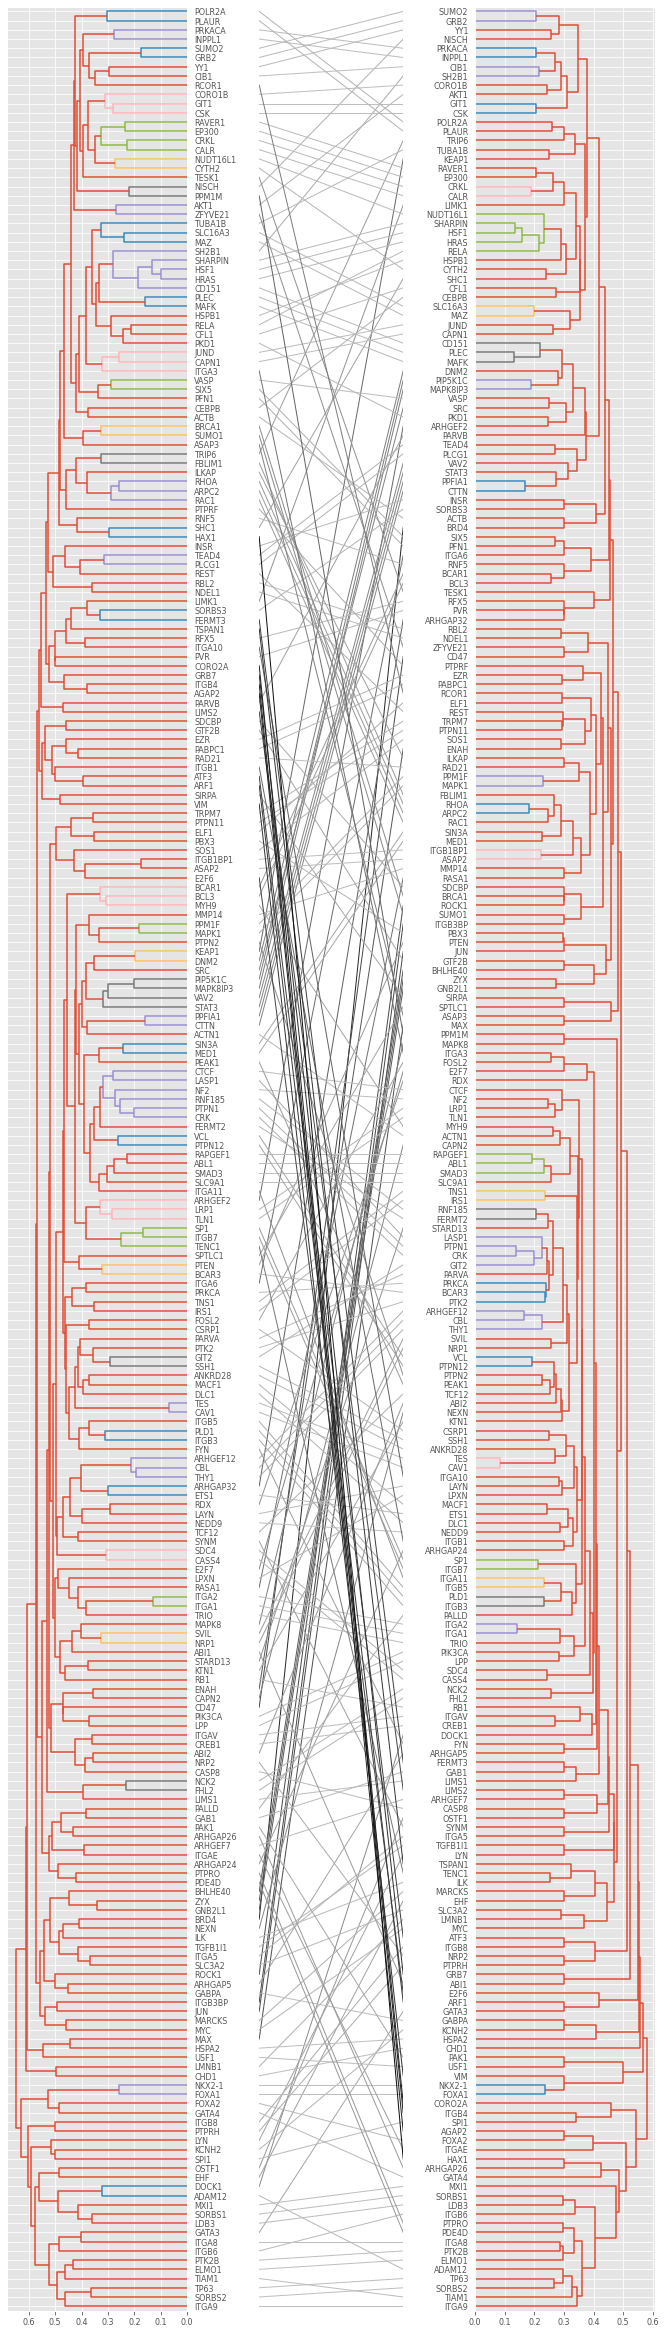

In [121]:
# Compare dendrograms with tanglegram
reload(tg)
plt.figure()
tg.plot(a=link1, b=link2,
        labelsA=sorted(G.nodes), labelsB=sorted(G.nodes),
        sort="step2side", 
        color_by_diff=True, t1=t1, t2=t2, figsize=(10,40))
plt.show()

## Check overlapping clustering

In [235]:
# Construct network
alpha = 0.99
inter_selected = adhesome_interX_edge_list
intra_selected = adhesome_intraX_edge_list
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(active_adhesome_genes)
A1 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='pearson_dist')
A2 = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic')
A = alpha*np.array(A1.todense())+(1-alpha)*(1-np.array(A2.todense()))
np.fill_diagonal(A,0)

In [224]:
# Construct network
hic_threshold = 0.1
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u]
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(active_adhesome_genes)
A_hic = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense()>0)
A = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='pearson_dist').todense())
A[A_hic==0] = A.max().max()
#A[A_hic==0] = 0.5
np.fill_diagonal(A,0)

In [236]:
# Create similarity matrix
B = 1-A
np.fill_diagonal(B,0)
D = np.diag(multi_dot([B, np.ones(len(B)).reshape(-1,1)]).flatten())
sq_inv_D = np.power(np.linalg.inv(D), 0.5)
C = multi_dot([sq_inv_D, B, sq_inv_D])

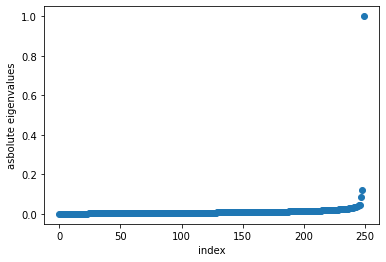

In [237]:
# Spectral decomposition of A (order eigenvalues and eigenvectors in decreasing magnitude)
w, v = np.linalg.eigh(C)
w = w[np.argsort(-np.abs(w))]
v = v[:,np.argsort(-np.abs(w))]

plt.figure()
plt.scatter(range(len(w)),sorted(np.abs(w)))
#plt.yscale('log')
plt.xlabel('index')
plt.ylabel('asbolute eigenvalues')
plt.show()

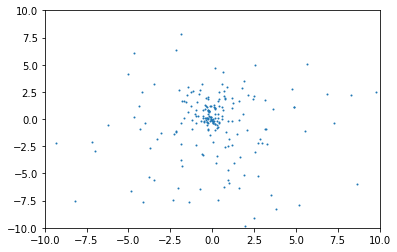

In [246]:
# SCORE embeddings
K = 10
Xi = v[:,:K]
Lambda = np.diag(w[:K])
R = (Xi/Xi[:,0].reshape(-1,1))[:,1:]
plt.figure()
plt.scatter(R[:,0], R[:,1], s=1)
l = 10
plt.xlim(-l,l)
plt.ylim(-l,l)
plt.show()

In [65]:
R

array([[-2.34088661e-01,  1.45986717e+00],
       [-4.71691961e+00,  3.68984712e+00],
       [ 1.04301071e+00,  9.71797198e-01],
       [-9.97527595e-01,  3.07630110e-02],
       [ 8.06792958e-01,  8.21004578e-01],
       [-3.85788883e-01, -3.10871177e-01],
       [-1.68822318e+00,  2.00630466e+00],
       [-1.62808542e+00, -1.69333058e+00],
       [-7.65820632e+00,  3.41391817e+00],
       [-2.35218861e+00, -6.45100196e+00],
       [-7.88348744e-01,  1.75289128e-01],
       [-8.60414027e-01, -1.38593062e+00],
       [-2.14918801e-01,  2.89777683e-01],
       [-9.97103552e-02,  2.83123679e+00],
       [-5.64711088e+00,  3.02725960e+00],
       [ 1.70713920e-01,  7.58362747e-01],
       [-6.31264342e-01,  8.80321938e-01],
       [ 3.08655793e-01, -5.88059353e-01],
       [ 1.30815519e+01, -7.06325602e+00],
       [-7.98409497e-01,  7.16650946e-01],
       [ 1.47158583e+00,  1.87172986e+01],
       [ 2.16779580e+00, -2.51317225e+00],
       [ 4.63888706e+00,  4.16385303e-01],
       [-3.

In [52]:
# Construct network
hic_threshold = 0.75
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u]
intra_selected = intra_selected[['source','target','hic','scaled_hic','pearson_dist','spearman_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','pearson_dist','spearman_dist'])
G.add_nodes_from(active_adhesome_genes)
A = nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic')
A = np.array(A.todense())
np.fill_diagonal(A,0)

# Compute dendrogram
y = A[np.triu_indices(n=len(A),k=1)]
linked = linkage(y, method='single')

# # Select HC threshold so that 4 chromosomes max
# dendrogram_height = linked[-1,2]
# for hc_threshold in np.linspace(start=0, stop=dendrogram_height, num=50, endpint=True):
#     clustering = fcluster(linked, t=hc_threshold, criterion='distance')


In [51]:
cophenet(linked, y)

(0.27963795585417917,
 array([0.        , 0.        , 0.05763186, ..., 0.20167023, 0.09843819,
        0.20167023]))

/home/louiscam/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:2872: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim([dvw, 0])


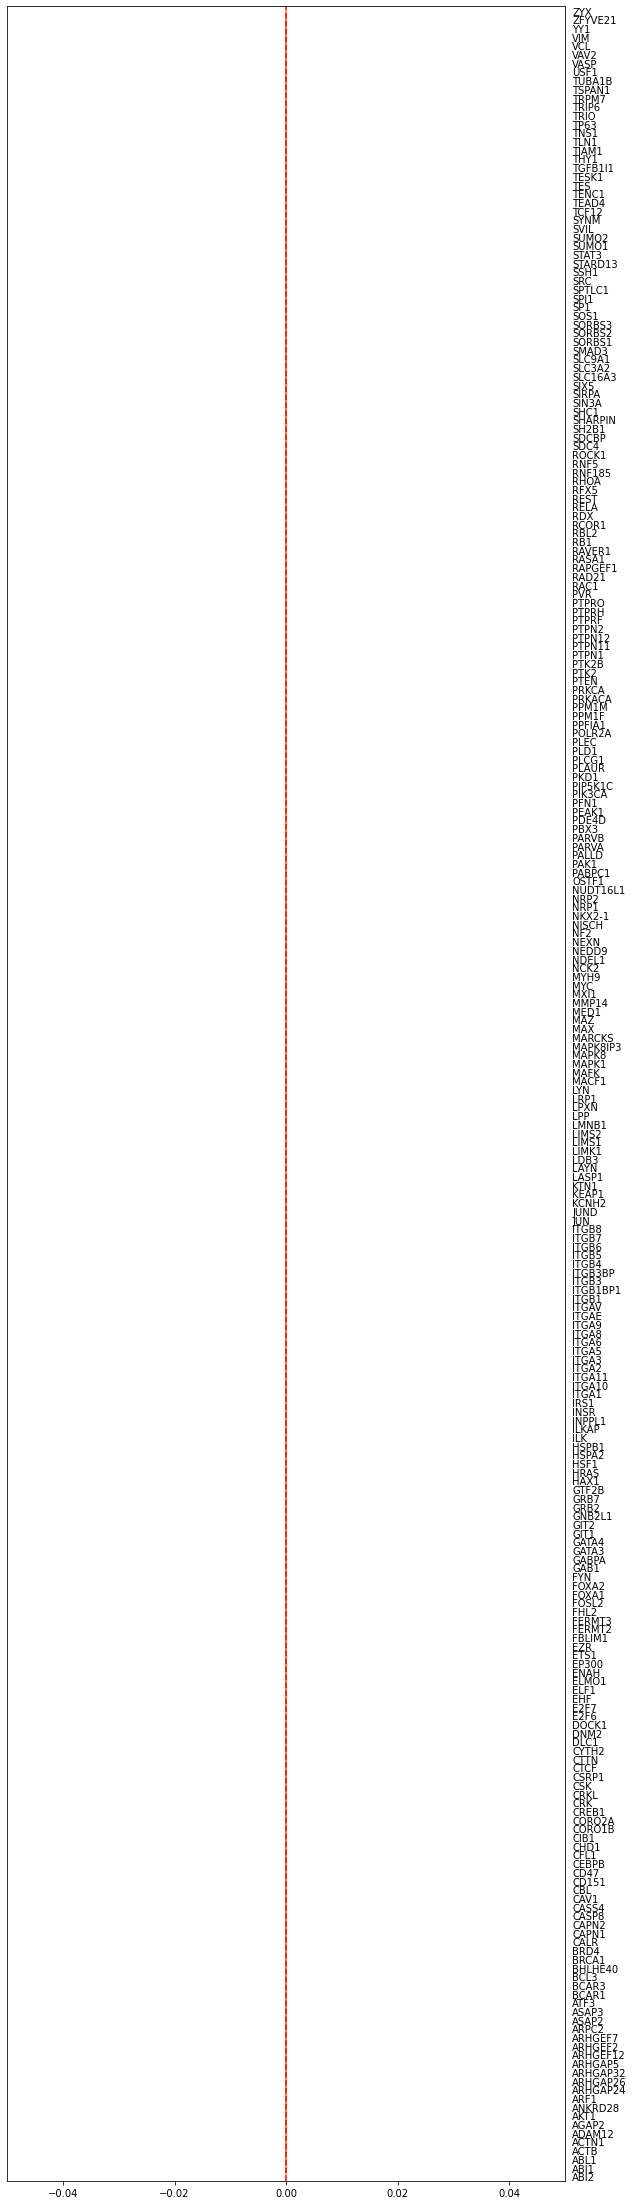

In [41]:
# Plot dendrogram

plt.figure(figsize=(10, 40))
dendrogram(linked,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=1)
plt.vlines(x=0, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

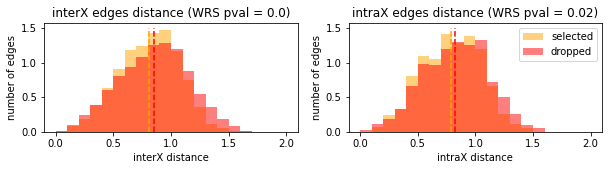

In [15]:
# Compare distribution of distances for edges that were dropped and edges that were kept
hic_threshold = 0.75
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u]
inter_dropped = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']<=t]
intra_dropped = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']<=u]
plt.figure(figsize=(10,2))
# interX
plt.subplot(1, 2, 1)
plt.hist(inter_selected['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='orange', alpha=0.5, label='selected')
plt.hist(inter_dropped['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='red', alpha=0.5, label='dropped')
plt.vlines(x=np.mean(inter_selected['distance']), ymin=0, ymax=1.5, color='orange', linestyle='dashed')
plt.vlines(x=np.mean(inter_dropped['distance']), ymin=0, ymax=1.5, color='red', linestyle='dashed')
plt.xlabel('interX distance')
plt.ylabel('number of edges')
wrs_pval = np.round(ss.ranksums(inter_selected['distance'], inter_dropped['distance'])[1],2)
plt.title('interX edges distance (WRS pval = '+str(wrs_pval)+')')

# intraX
plt.subplot(1, 2, 2)
plt.hist(intra_selected['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='orange', alpha=0.5, label='selected')
plt.hist(intra_dropped['distance'], bins=np.arange(0,2.1,0.1), density=True,
         color='red', alpha=0.5, label='dropped')
plt.vlines(x=np.mean(intra_selected['distance']), ymin=0, ymax=1.5, color='orange', linestyle='dashed')
plt.vlines(x=np.mean(intra_dropped['distance']), ymin=0, ymax=1.5, color='red', linestyle='dashed')
plt.xlabel('intraX distance')
plt.ylabel('number of edges')
wrs_pval = np.round(ss.ranksums(intra_selected['distance'], intra_dropped['distance'])[1],2)
plt.title('intraX edges distance (WRS pval = '+str(wrs_pval)+')')
plt.legend(loc='upper right')
plt.show()

# HC clustering analysis

In [123]:
# Parameters
hic_threshold = 0.75
with_intra = True
weights = 'distance'

In [124]:
# Selected edge list
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target','hic','scaled_hic','distance']]
adhesome_edge_list = inter_selected
if with_intra == True:
    adhesome_edge_list = pd.concat([adhesome_edge_list,intra_selected])
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic','distance'])
G.add_nodes_from(selected_genes)

In [125]:
# Perform HC with various thresholds
threshold_list = np.arange(0,2,0.01)
n_clusters = []
max_genes_per_cluster = []
max_chrom_per_cluster = []
for hc_threshold in tqdm(threshold_list):
    # Cluster
    clustering_graph2_hc = cc.hierarchical_clustering2(adhesome_interX_edge_list, 
                                                      adhesome_intraX_edge_list,
                                                      selected_genes,
                                                      hic_threshold,
                                                      with_intra,
                                                      weights,
                                                      hc_threshold,
                                                      hc_method='ward',
                                                      plot=False)
    # Create graph with metadata
    cG = G.copy()
    labels = np.array(sorted(cG.nodes))
    n = len(labels)
    nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_hc[i]) for i in range(n)}, "hc_cluster")
    nx.set_node_attributes(cG, {labels[i]: adh_and_tf_chr_loci[adh_and_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
    # Record results
    n_clusters.append(len(np.unique(clustering_graph2_hc)))
    max_genes_per_cluster.append(np.max(np.unique(clustering_graph2_hc, return_counts=True)[1]))
    max_chrom_per_cluster.append(oi.get_networkx_graph_as_dataframe_of_nodes(cG).groupby('hc_cluster')['chromosome'].nunique().max())
n_clusters = np.array(n_clusters)
max_genes_per_cluster = np.array(max_genes_per_cluster)

100%|██████████| 200/200 [00:32<00:00,  6.18it/s]


Threshold = 0.76


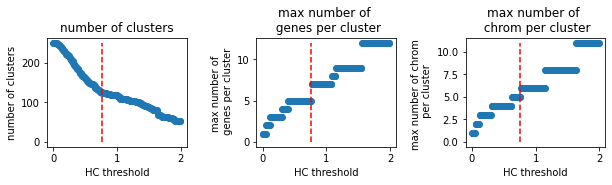

In [126]:
# Performance of different HC thresholds
t_critic = threshold_list[np.min(np.where(np.array(max_chrom_per_cluster)>5)[0])-1]
print('Threshold = '+str(t_critic))
plt.figure(figsize=(10,2))
plt.subplots_adjust(wspace=.5)
plt.subplot(1, 3, 1)
plt.scatter(threshold_list, n_clusters)
plt.vlines(x=t_critic, ymin=0, ymax=max(n_clusters), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('number of clusters')
plt.title('number of clusters')

plt.subplot(1, 3, 2)
plt.scatter(threshold_list, max_genes_per_cluster)
plt.vlines(x=t_critic, ymin=0, ymax=max(max_genes_per_cluster), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('max number of \n genes per cluster')
plt.title('max number of \n genes per cluster')

plt.subplot(1, 3, 3)
plt.scatter(threshold_list, max_chrom_per_cluster)
plt.vlines(x=t_critic, ymin=0, ymax=max(max_chrom_per_cluster), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('max number of chrom \n per cluster')
plt.title('max number of \n chrom per cluster')
plt.show()

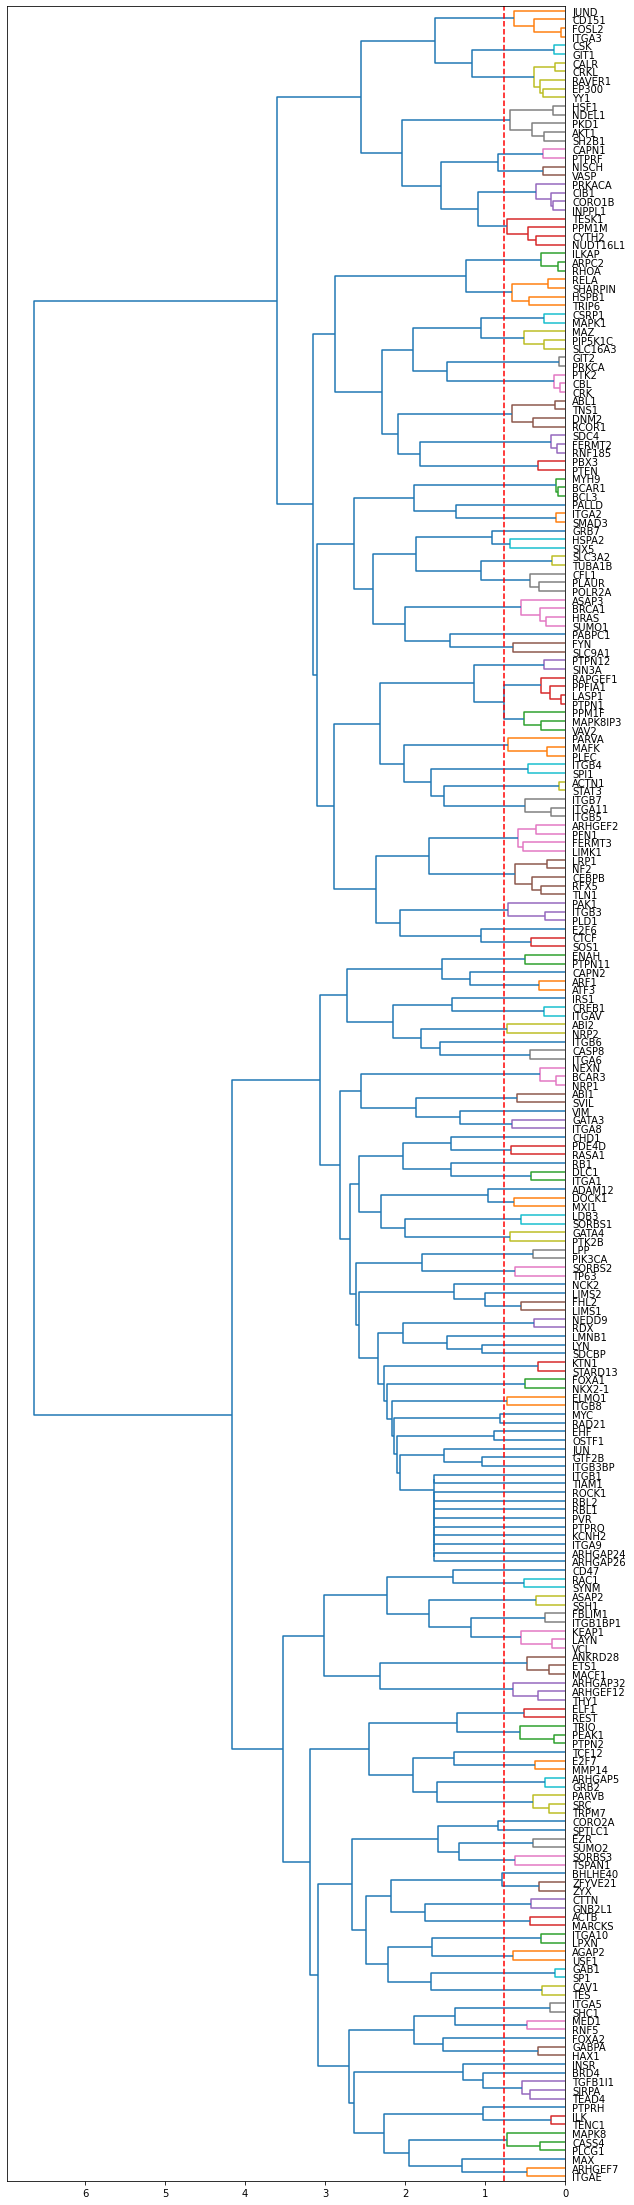

Number of clusters = 126
Number of singletons = 44
Number of nodes in non trivial clusters = 207
Size of clusters


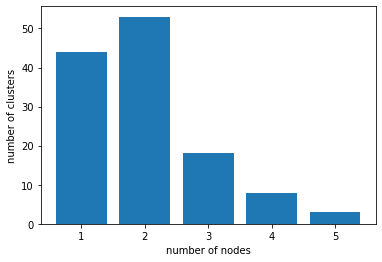

In [127]:
#Run HC
reload(cc)
hc_threshold = t_critic
clustering_graph2_hc = cc.hierarchical_clustering2(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  selected_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  hc_method='ward',
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of clusters')
plt.show()

In [129]:
# Create a clique graph corresponding to this clustering
clique_edgelist = pd.DataFrame(columns=['source','target','weight'])
for i in np.arange(len(selected_genes)):
    for j in np.arange(i+1, len(selected_genes)):
        if clustering_graph2_hc[i]==clustering_graph2_hc[j]:
            new_edge = pd.DataFrame({'source': [selected_genes[i]],
                                     'target': [selected_genes[j]],                
                                     'weight': [1]})
            clique_edgelist = clique_edgelist.append(new_edge)
cliqueG = nx.from_pandas_edgelist(clique_edgelist, edge_attr=['weight'])
pickle.dump(cliqueG, open(saving_dir+'initial_cliqueG.pkl', 'wb'))

In [32]:
# Clustered graph
cG = G.copy()
labels = np.array(sorted(cG.nodes))
n = len(labels)
# Add cluster information for each node
nx.set_node_attributes(cG, {labels[i]: str(clustering_graph2_hc[i]) for i in range(n)}, "hc_cluster")
# Add chromosome information for each node
nx.set_node_attributes(cG, {labels[i]: adh_and_tf_chr_loci[adh_and_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Drop singletons
singleton_clusters = np.where(np.unique(clustering_graph2_hc, return_counts=True)[1]==1)[0]+1
singletons = labels[np.where([node_cluster in singleton_clusters for node_cluster in clustering_graph2_hc])]
cG.remove_nodes_from(singletons)
# Save network to html
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_intra.html")
#oi.output_networkx_graph_as_interactive_html(cG, filename=saving_dir+"clusteredG_hc_nointra.html")

<Figure size 432x288 with 0 Axes>

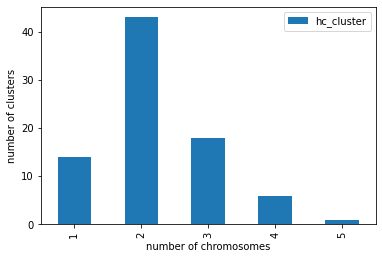

In [48]:
# Plot number of chromosomes per cluster
plt.figure()
oi.get_networkx_graph_as_dataframe_of_nodes(cG).groupby('hc_cluster')['chromosome'].nunique().reset_index().groupby('chromosome').count().plot.bar()
plt.xlabel('number of chromosomes')
plt.ylabel('number of clusters')
plt.show()

### Robustness of HC

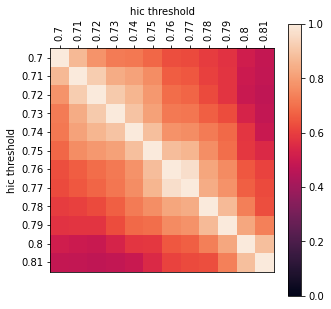

In [50]:
# Load AMI heatmap
ami_table = pickle.load(open(saving_dir+'ami_intra_hc.pickle','rb'))
#ami_table = pickle.load(open(saving_dir+'ami_nointra_hc.pickle','rb'))
# Plot heatmap
lu.plot_heatmap(ami_table.astype('float'), list(ami_table.index), list(ami_table.index), 'hic threshold', 'hic threshold', 5, 0, 1, fontsize=10)

-----------------------------------------------------------------------------------------------------------------

# Final network and clustering

In [51]:
# Load gene to chromosome dict
gene2chrom = pickle.load(open(saving_dir+'gene2chrom.pkl','rb'))
# Load hTFtarget data set
active_lung_tf2target = pickle.load(open(saving_dir+'active_lung_tf2target.pkl', 'rb'))
active_lung_target2tf = pickle.load(open(saving_dir+'active_lung_target2tf.pkl', 'rb'))
# All genes
all_active_genes = pickle.load(open(saving_dir+'all_active_genes.pkl', 'rb'))
# Metadata
active_lung_tf_genes = pickle.load(open(saving_dir+'active_lung_tf_genes.pkl','rb'))
proteins_df = pickle.load(open(dir_proteins+'mechanoreg_proteins.pkl', 'rb'))
collagens = proteins_df[proteins_df['family']=='collagen']['geneSymbol'].values
lamins = proteins_df[proteins_df['family']=='lamin']['geneSymbol'].values
lims = proteins_df[proteins_df['family']=='LIM']['geneSymbol'].values
mmps = proteins_df[proteins_df['family']=='MMP']['geneSymbol'].values
elastin = proteins_df[proteins_df['family']=='elastin']['geneSymbol'].values
fibronectin = proteins_df[proteins_df['family']=='fibronectin']['geneSymbol'].values
tenascins = proteins_df[proteins_df['family']=='tenascin']['geneSymbol'].values

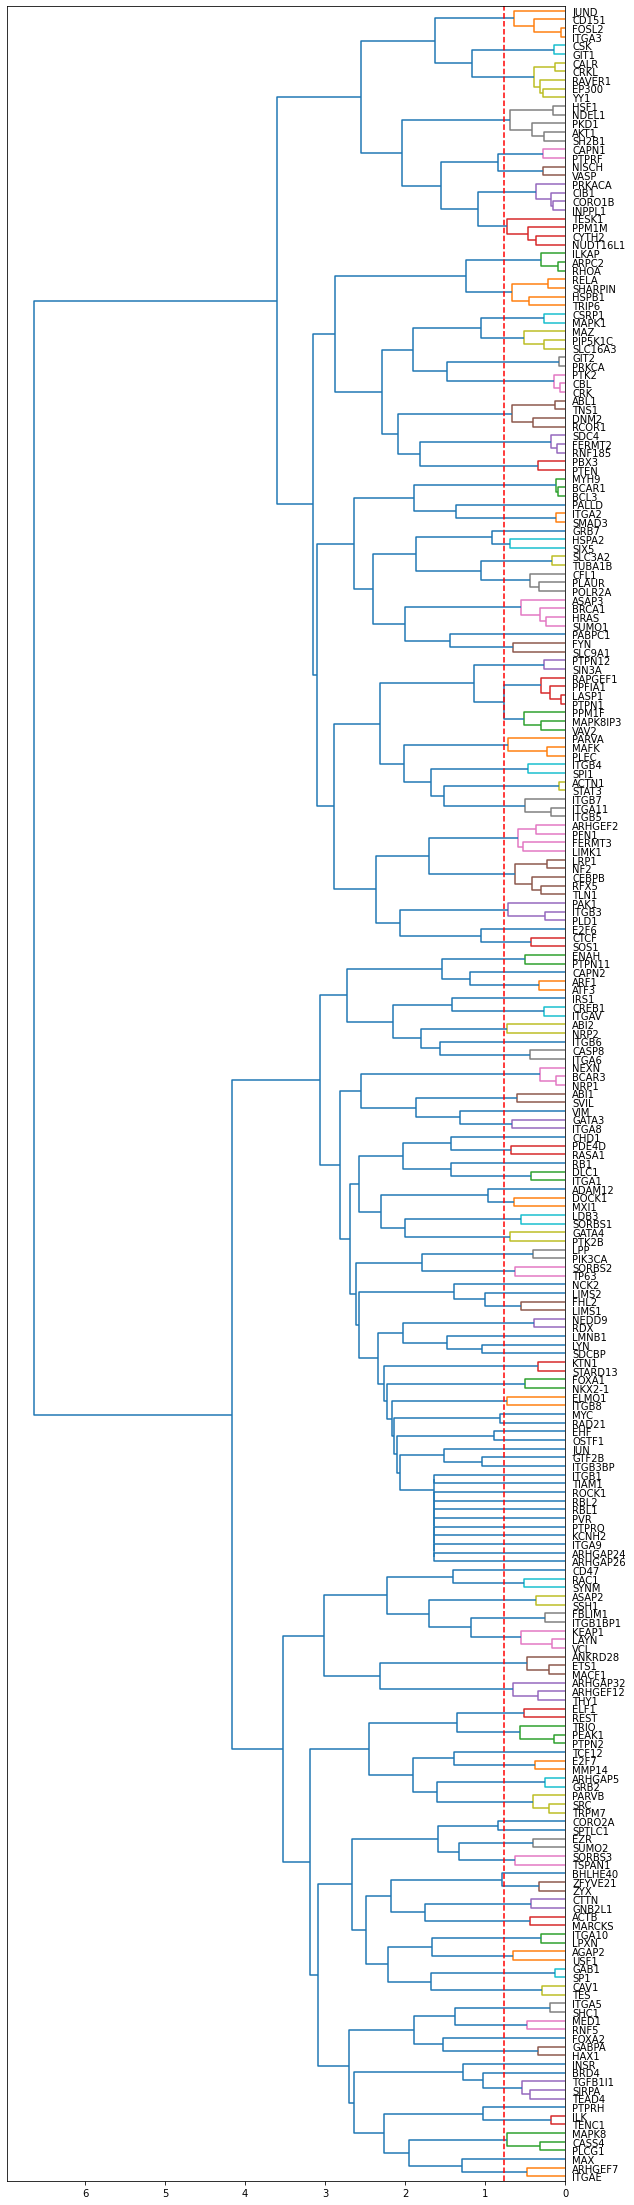

Number of clusters = 126
Number of singletons = 44
Number of nodes in non trivial clusters = 207
Size of clusters


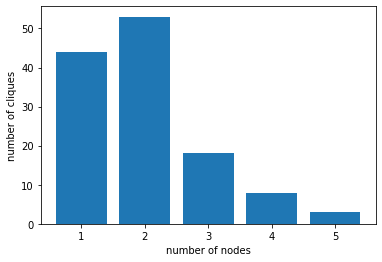

In [52]:
#Run HC
reload(cc)
hc_threshold = 0.76
clustering_graph2_hc = cc.hierarchical_clustering2(adhesome_interX_edge_list, 
                                                  adhesome_intraX_edge_list,
                                                  selected_genes,
                                                  hic_threshold,
                                                  with_intra,
                                                  weights,
                                                  hc_threshold,
                                                  hc_method='ward',
                                                  plot=True)
# Clustering characteristics
comps = np.unique(np.unique(clustering_graph2_hc, return_counts=True)[1],return_counts=True)
print('Number of clusters = '+str(len(np.unique(clustering_graph2_hc))))
print('Number of singletons = '+str(comps[1][0]))
print('Number of nodes in non trivial clusters = '+str(len(clustering_graph2_hc)-comps[1][0]))
print('Size of clusters')
plt.figure()
plt.bar(x=comps[0], height=comps[1])
plt.xlabel('number of nodes')
plt.ylabel('number of cliques')
plt.show()

In [53]:
# Create dataframe with cluster
clusters_df = pd.DataFrame({'genes': selected_genes, 'cluster': clustering_graph2_hc})
clusters_df = clusters_df.groupby(['cluster']).agg({'genes':lambda x : list(x)}). reset_index()
clusters_df['chromosomes'] = [[gene2chrom[g] for g in clusters_df.iloc[i]['genes']]
                                    for i in range(clusters_df.shape[0])]
clusters_df['n_chromosomes'] = [len(np.unique(clusters_df.iloc[i]['chromosomes'])) for i in range(clusters_df.shape[0])]

In [54]:
# Annotate adhesome genes and TF genes
clusters_df['adhesome_genes'] = [[gene for gene in clusters_df.iloc[i]['genes'] 
                                        if gene in active_adhesome_genes]
                                      for i in range(clusters_df.shape[0])]
clusters_df['tf_genes'] = [[gene for gene in clusters_df.iloc[i]['genes'] 
                                        if gene in active_lung_adhesome_tf_genes]
                                      for i in range(clusters_df.shape[0])]

In [55]:
# Cluster size
clusters_df['size_genes'] = [len(clusters_df.iloc[i]['genes']) for i in range(clusters_df.shape[0])]
clusters_df['size_tf_genes'] = [len(clusters_df.iloc[i]['tf_genes']) for i in range(clusters_df.shape[0])]
clusters_df = clusters_df.sort_values(by=['size_genes', 'size_tf_genes'], ascending=False)
# Only keep clusters with more than 2 genes
clusters_df = clusters_df[clusters_df['size_genes']>1]

In [56]:
# Specificity of TFs
clusters_df['prop_adhesome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(active_adhesome_genes)))/len(active_adhesome_genes),3) for tf in clusters_df.iloc[i]['tf_genes']]
                                              for i in range(clusters_df.shape[0])]
clusters_df['prop_genome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(all_active_genes)))/len(all_active_genes),3) for tf in clusters_df.iloc[i]['tf_genes']]
                                              for i in range(clusters_df.shape[0])]

In [72]:
# Print stats
print('Number of clusters = '+str(clusters_df.shape[0]))
print('Number of genes in clusters = '+str(len(np.unique(sorted(itertools.chain.from_iterable(clusters_df['genes']))))))
pickle.dump(clusters_df, open(saving_dir+'adhesome_clusters_df.pkl', 'wb'))
clusters_df[clusters_df['size_tf_genes']>0]

Number of clusters = 82
Number of genes in clusters = 207


cluster                             genes  \
2          3  [CALR, CRKL, EP300, RAVER1, YY1]   
35        36    [CEBPB, LRP1, NF2, RFX5, TLN1]   
3          4  [AKT1, HSF1, NDEL1, PKD1, SH2B1]   
0          1       [CD151, FOSL2, ITGA3, JUND]   
24        25       [ASAP3, BRCA1, HRAS, SUMO1]   
9         10     [HSPB1, RELA, SHARPIN, TRIP6]   
14        15         [ABL1, DNM2, RCOR1, TNS1]   
11        12           [MAZ, PIP5K1C, SLC16A3]   
17        18               [BCAR1, BCL3, MYH9]   
23        24             [CFL1, PLAUR, POLR2A]   
30        31               [MAFK, PARVA, PLEC]   
94        95            [ANKRD28, ETS1, MACF1]   
118      119           [SIRPA, TEAD4, TGFB1I1]   
69        70                   [FOXA1, NKX2-1]   
96        97                      [ELF1, REST]   
16        17                      [PBX3, PTEN]   
18        19                    [ITGA2, SMAD3]   
20        21                     [HSPA2, SIX5]   
27        28                   [PTPN12, SIN3A]   
31        32                     [ITGB4, SPI1]   
37        38                      [CTCF, SOS1]   
40        41                      [ARF1, ATF3]   
42        43                    [CREB1, ITGAV]   
49        50                    [GATA3, ITGA8]   
55        56                     [DOCK1, MXI1]   
58        59                    [GATA4, PTK2B]   
60        61                    [SORBS2, TP63]   
98        99                     [E2F7, MMP14]   
104      105                      [EZR, SUMO2]   
111      112                     [AGAP2, USF1]   
112      113                       [GAB1, SP1]   
115      116                      [MED1, RNF5]   
116      117                     [GABPA, HAX1]   

                             chromosomes  n_chromosomes  \
2    [chr19, chr22, chr22, chr19, chr14]              3   
35     [chr20, chr12, chr22, chr1, chr9]              5   
3     [chr14, chr8, chr17, chr16, chr16]              4   
0            [chr11, chr2, chr17, chr19]              4   
24            [chr1, chr17, chr11, chr2]              4   
9              [chr7, chr11, chr8, chr7]              3   
14            [chr9, chr19, chr14, chr2]              4   
11                 [chr16, chr19, chr17]              3   
17                 [chr16, chr19, chr22]              3   
23                 [chr11, chr19, chr17]              3   
30                   [chr7, chr11, chr8]              3   
94                   [chr3, chr11, chr1]              3   
118                [chr20, chr12, chr16]              3   
69                        [chr14, chr14]              1   
96                         [chr13, chr4]              2   
16                         [chr9, chr10]              2   
18                         [chr5, chr15]              2   
20                        [chr14, chr19]              2   
27                         [chr7, chr15]              2   
31                        [chr17, chr11]              2   
37                         [chr16, chr2]              2   
40                          [chr1, chr1]              1   
42                          [chr2, chr2]              1   
49                        [chr10, chr10]              1   
55                        [chr10, chr10]              1   
58                          [chr8, chr8]              1   
60                          [chr4, chr3]              2   
98                        [chr12, chr14]              2   
104                        [chr6, chr17]              2   
111                        [chr12, chr1]              2   
112                        [chr4, chr12]              2   
115                        [chr17, chr6]              2   
116                        [chr21, chr1]              2   

                 adhesome_genes         tf_genes  size_genes  size_tf_genes  \
2          [CALR, CRKL, RAVER1]     [EP300, YY1]           5              2   
35            [LRP1, NF2, TLN1]    [CEBPB, RFX5]           5              2   
3    [AKT1, NDEL1, PKD1, SH2B1]           [HSF1]           5

---------

# Build network of clusters

In [65]:
# Build network of clusters
edge_list = pd.DataFrame(columns=['source','target','source_id','target_id','weight','TFs'])
to_remove = []
for i in range(len(clusters_df)):
    for j in range(len(clusters_df)):
        # Cluster nodes
        cluster1 = format_node_label(clusters_df.iloc[i]['genes'])
        cluster2 = format_node_label(clusters_df.iloc[j]['genes'])
        # Clusters ID
        cluster1_id = clusters_df.iloc[i]['cluster']
        cluster2_id = clusters_df.iloc[j]['cluster']
        # Nodes in clusters
        cluster1_tfs = clusters_df.iloc[i]['tf_genes']
        cluster1_tfs = list(set(clusters_df.iloc[i]['tf_genes'])-set(to_remove))
        cluster1_tfs_spec = clusters_df.iloc[i]['prop_genome_targets']
        cluster2_nodes = clusters_df.iloc[j]['genes']
        # Normalized edge weight
        n_target_genes = len(cluster2_nodes)
        n_tf_genes = len(cluster1_tfs)
        if n_tf_genes>0: 
            tfs_involved_in_edge = [tf for tf in cluster1_tfs
                                    if len(active_lung_tf2target[tf].intersection(set(cluster2_nodes)))>0]
#             weight = np.sum(np.array([len(active_lung_tf2target[cluster1_tfs[i]].intersection(set(cluster2_nodes)))*(1-cluster1_tfs_spec[i])
#                                       for i in range(len(cluster1_tfs))]))/(n_target_genes*n_tf_genes)
            weight = np.sum(np.array([len(active_lung_tf2target[cluster1_tfs[i]].intersection(set(cluster2_nodes)))
                                     for i in range(len(cluster1_tfs))]))/(n_target_genes*n_tf_genes)
            # Create edge
            new_edge = pd.DataFrame({'source': [cluster1],
                                     'target': [cluster2],                
                                     'source_id': [cluster1_id],
                                     'target_id': [cluster2_id],
                                     'weight':[weight],
                                     'TFs': [','.join(tfs_involved_in_edge)]})
            edge_list = edge_list.append(new_edge)
edge_list = edge_list[edge_list['weight']>0]

In [66]:
# Create graph
G = nx.from_pandas_edgelist(edge_list, edge_attr=['weight','TFs'], create_using=nx.DiGraph)
# Add node metadata
n = len(G.nodes)
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['adhesome_genes']) for i in range(n)}, 
                       "n_adhesome")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['tf_genes']) for i in range(n)}, 
                       "n_TFs")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['adhesome_genes'] for i in range(n)}, 
                       "all_adhesomes")
nx.set_node_attributes(G, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['tf_genes'] for i in range(n)}, 
                       "all_TFs")
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 82
Number of edges: 1207
Average in degree:  14.7195
Average out degree:  14.7195


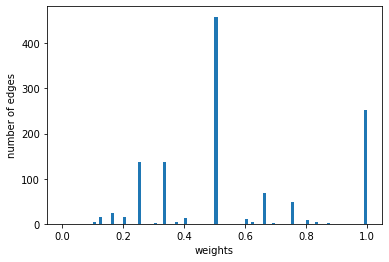

In [67]:
# Distribution of edge weights
plt.figure()
plt.hist(edge_list['weight'], bins=np.arange(0,1.01,0.01))
#plt.vlines(x=0.55, ymin=0, ymax=350, color='red', linestyle='dashed')
plt.xlabel('weights')
plt.ylabel('number of edges')
plt.show()

In [96]:
# Define network object
net  = Network(height="1000px",
               width="1000px",
               directed=True,
               font_color='black',
               notebook=True,
               layout=None,
               heading='Adhesome network')

# Set layout
net.hrepulsion(node_distance=200,
               central_gravity=0.0,
               spring_length=100,
               spring_strength=0.01,
               damping=0.09)

# Import NetworkX graph
from_nx(G, net, default_node_size=20, 
        default_edge_weight=1,edge_weight_scale=0.1, edge_color_scale=1, edge_threshold=0.6, 
        hidden_edges=to_remove,
        shape='box')
#net.show_buttons()
net.show("adhesome_network.html")

In [115]:
# Self reinforcing edges
self_edge_list = edge_list[edge_list['source']==edge_list['target']]
# Create graph
Gself = nx.from_pandas_edgelist(self_edge_list, edge_attr=['weight','TFs'], create_using=nx.DiGraph)
# Add node metadata
n = len(G.nodes)
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['adhesome_genes']) for i in range(n)}, 
                       "n_adhesome")
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): len(clusters_df.iloc[i]['tf_genes']) for i in range(n)}, 
                       "n_TFs")
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['adhesome_genes'] for i in range(n)}, 
                       "all_adhesomes")
nx.set_node_attributes(Gself, 
        {format_node_label(clusters_df.iloc[i]['genes']): clusters_df.iloc[i]['tf_genes'] for i in range(n)}, 
                       "all_TFs")
print(nx.info(Gself))

Name: 
Type: DiGraph
Number of nodes: 18
Number of edges: 18
Average in degree:   1.0000
Average out degree:   1.0000


In [119]:
# Define network object
net  = Network(height="1000px",
               width="1000px",
               directed=True,
               font_color='black',
               notebook=True,
               layout=None,
               heading='Adhesome network')

# Set layout
net.hrepulsion(node_distance=200,
               central_gravity=0.0,
               spring_length=100,
               spring_strength=0.01,
               damping=0.09)

# Import NetworkX graph
from_nx(Gself, net, default_node_size=20, 
        default_edge_weight=1,edge_weight_scale=0.1, edge_color_scale=1, edge_threshold=0, 
        hidden_edges=[],
        shape='box')
#net.show_buttons()
net.show("self_adhesome_network.html")

In [106]:
oi.get_networkx_graph_as_dataframe_of_nodes(Gself)

n_adhesome  n_TFs         all_adhesomes  \
CALR CRKL \n  EP300 RAVER1 \n  YY1           3      2  [CALR, CRKL, RAVER1]   
CEBPB LRP1 \n  NF2 RFX5 \n  TLN1             3      2     [LRP1, NF2, TLN1]   
CD151 FOSL2 \n  ITGA3 JUND                   2      2        [CD151, ITGA3]   
MAZ PIP5K1C \n  SLC16A3                      2      1    [PIP5K1C, SLC16A3]   
BCAR1 BCL3 \n  MYH9                          2      1         [BCAR1, MYH9]   
CFL1 PLAUR \n  POLR2A                        2      1         [CFL1, PLAUR]   
ANKRD28 ETS1 \n  MACF1                       2      1      [ANKRD28, MACF1]   
SIRPA TEAD4 \n  TGFB1I1                      2      1      [SIRPA, TGFB1I1]   

                                          all_TFs  
CALR CRKL \n  EP300 RAVER1 \n  YY1   [EP300, YY1]  
CEBPB LRP1 \n  NF2 RFX5 \n  TLN1    [CEBPB, RFX5]  
CD151 FOSL2 \n  ITGA3 JUND          [FOSL2, JUND]  
MAZ PIP5K1C \n  SLC16A3                     [MAZ]  
BCAR1 BCL3 \n  MYH9                        [BCL3]  
CFL1 PLAUR \n  POLR2A                    [POLR2A]  
ANKRD28 ETS1 \n  MACF1                     [ETS1]  
SIRPA TEAD4 \n  TGFB1I1                   [TEAD4]

# Helper functions

In [62]:
def format_node_label(raw_label):
    '''
    Function to put node label in a square format
    Args:
        raw_label: (Numpy array) array of gene names
    Returns:
        The formatted label (a string)
    '''
    label = raw_label.copy()   
    # Line breaks
    for i in range(1, len(labels)//2+1):
        if 2*i<len(label):
            label[2*i-1] = label[2*i-1]+' \n '
    label = ' '.join(label)
    return label

In [116]:
def from_nx(graph, pyvisnet, default_node_size=1, 
            default_edge_weight=1, edge_weight_scale=1, edge_color_scale=1, edge_threshold=0, hidden_edges=[], 
            shape='circle'):
    """
    This method takes an exisitng Networkx graph and translates
    it to a PyVis graph format that can be accepted by the VisJs
    API in the Jinja2 template. This operation is done in place.
    """
    nx_graph = graph.copy()
    assert(isinstance(nx_graph, nx.Graph))
    edges = nx_graph.edges(data=True)
    nodes = nx_graph.nodes(data=True)

    if len(edges) > 0:
        for e in edges:
            # Specify node size
            if 'size' not in nodes[e[0]].keys():
                nodes[e[0]]['size'] = default_node_size
            nodes[e[0]]['size'] = int(nodes[e[0]]['size'])
            if 'size' not in nodes[e[1]].keys():
                nodes[e[1]]['size'] = default_node_size
            nodes[e[1]]['size'] = int(nodes[e[1]]['size'])
            # Specify node color
            if nodes[e[0]]['n_TFs']>0:
                nodes[e[0]]['color'] = 'lightcoral'
            else:
                nodes[e[0]]['color'] = 'dodgerblue'
            if nodes[e[1]]['n_TFs']>0:
                nodes[e[1]]['color'] = 'lightcoral'
            else:
                nodes[e[1]]['color'] = 'dodgerblue'
            # Specify node title
            if len(nodes[e[0]]['all_TFs'])>0:
                nodes[e[0]]['title'] = 'adhesome: '+','.join(nodes[e[0]]['all_adhesomes'])+' / '+'TFs: '+','.join(nodes[e[0]]['all_TFs'])
            else:
                nodes[e[0]]['title'] = 'adhesome: '+','.join(nodes[e[0]]['all_adhesomes'])+' / '+'no TF'
            if nodes[e[1]]['n_TFs']>0:
                nodes[e[1]]['title'] = 'adhesome: '+','.join(nodes[e[1]]['all_adhesomes'])+' / '+'TFs: '+','.join(nodes[e[1]]['all_TFs'])
            else:
                nodes[e[1]]['title'] = 'adhesome: '+','.join(nodes[e[1]]['all_adhesomes'])+' / '+'no TF'
            pyvisnet.add_node(e[0], **nodes[e[0]], shape=shape)
            pyvisnet.add_node(e[1], **nodes[e[1]], shape=shape)

            if 'weight' not in e[2].keys():
                e[2]['weight'] = default_edge_weight
            edge_dict = e[2].copy()
            edge_dict["value"] = e[2]['weight']*edge_weight_scale
            edge_dict["title"] = 'TF: '+e[2]['TFs']+'\n'+'val: '+str(e[2]['weight'])
            edge_dict["color"] = colfunc(e[2]['weight']*edge_color_scale)
            edge_dict["arrowStrikethrough"] = False
            if (e[2]['weight']>edge_threshold) and (e[2]['TFs'] not in hidden_edges):
                pyvisnet.add_edge(e[0], e[1], **edge_dict)

    for node in nx.isolates(nx_graph):
        if 'size' not in nodes[node].keys():
            nodes[node]['size']=default_node_size
        pyvisnet.add_node(node, **nodes[node], shape=shape)

In [64]:
def colfunc(val, minval=0, maxval=1):
    """ Convert value in the range minval...maxval to a color in the range
        startcolor to stopcolor. The colors passed and the one returned are
        composed of a sequence of N component values (e.g. RGB).
    """
    RED, YELLOW, GREEN  = (1, 0, 0), (1, 1, 0), (0, 1, 0)
    CYAN, BLUE, MAGENTA = (0, 1, 1), (0, 0, 1), (1, 0, 1)
    WHITE = (1, 1, 1)
    f = float(val-minval) / (maxval-minval)
    return mpl.colors.rgb2hex(tuple(f*(b-a)+a for (a, b) in zip(WHITE, RED)))

# Specificity of adhesome TFs

In [77]:
# How specific are adhesome TFs
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
htargettf_df = pd.read_csv(dir_htftarget+'hTFtarget.txt', sep='\t', header=0)
htargettf_df.columns = ['geneSymbol', 'target', 'tissue']
htargettf_lung_df = htargettf_df[htargettf_df['tissue'].str.contains('lung')]
htargettf_lung_df_adhesome = htargettf_lung_df[htargettf_lung_df['geneSymbol'].isin(active_lung_adhesome_tf_genes) &
                                               htargettf_lung_df['target'].isin(active_adhesome_genes)]

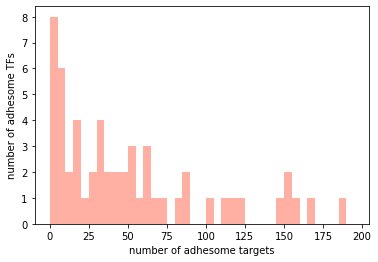

In [78]:
# Histogram of number of adhesome targets
plt.figure()
plt.hist(htargettf_lung_df_adhesome.groupby(['geneSymbol'])['target'].nunique(), 
         bins=np.arange(0,200,5), color='tomato', alpha=0.5, label='adhesome TFs')
plt.xlabel('number of adhesome targets')
plt.ylabel('number of adhesome TFs')
#plt.legend(loc='upper right')
plt.show()

In [87]:
# Specificity dataframe
spec_tf = htargettf_lung_df_adhesome.groupby(['geneSymbol'])['target'].nunique().reset_index()
spec_tf['pct_target'] = spec_tf['target']/len(active_adhesome_genes)
spec_tf = spec_tf.sort_values('target', ascending=False)
spec_tf

geneSymbol  target  pct_target
28        MAZ     189    0.964286
8        CTCF     166    0.846939
5       CEBPB     158    0.806122
25      LMNB1     153    0.780612
17      FOXA2     153    0.780612
47       SPI1     149    0.760204
13      EP300     123    0.627551
4        BRD4     117    0.596939
16      FOXA1     114    0.581633
27        MAX     102    0.520408
18      GABPA      89    0.454082
14       ETS1      85    0.433673
9        E2F6      84    0.428571
34     POLR2A      70    0.357143
46        SP1      66    0.336735
35      RAD21      64    0.326531
24       JUND      62    0.316327
50      TCF12      60    0.306122
21      GTF2B      55    0.280612
15      FOSL2      53    0.270408
7       CREB1      53    0.270408
1        BCL3      52    0.265306
33       PBX3      48    0.244898
19      GATA3      47    0.239796
43      SIN3A      44    0.224490
32     NKX2-1      44    0.224490
12       ELF1      38    0.193878
10       E2F7      35    0.178571
6        CHD1      34    0.173469
53       USF1      34    0.173469
49      SUMO2      33    0.168367
30       MXI1      32    0.163265
3       BRCA1      28    0.142857
54        YY1      26    0.132653
23        JUN      20    0.102041
44       SIX5      19    0.096939
20      GATA4      18    0.091837
26       MAFK      15    0.076531
2     BHLHE40      15    0.076531
45      SMAD3      13    0.066327
31        MYC      13    0.066327
11        EHF       9    0.045918
0        ATF3       9    0.045918
38       RBL2       8    0.040816
39      RCOR1       7    0.035714
36        RB1       6    0.030612
52       TP63       5    0.025510
41       REST       3    0.015306
40       RELA       3    0.015306
51      TEAD4       3    0.015306
42       RFX5       2    0.010204
48      SUMO1       2    0.010204
29       MED1       1    0.005102
22       HSF1       1    0.005102
37       RBL1       1    0.005102

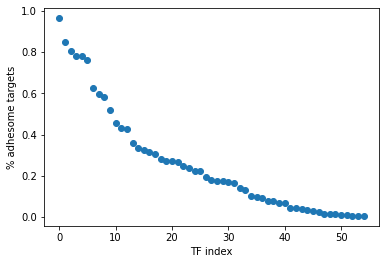

In [91]:
# Percentage of adhesome targets for adhesome TFs
plt.figure()
plt.scatter(range(len(spec_tf)),spec_tf['pct_target'])
plt.xlabel('TF index')
plt.ylabel('% adhesome targets')
plt.show()

In [95]:
# TFs to remove
to_remove = spec_tf[spec_tf['pct_target']>0.4]['geneSymbol'].values
to_remove

array(['MAZ', 'CTCF', 'CEBPB', 'LMNB1', 'FOXA2', 'SPI1', 'EP300', 'BRD4',
       'FOXA1', 'MAX', 'GABPA', 'ETS1', 'E2F6'], dtype=object)